# Evolutionary Game Theory Model of Morality

## Abstract

|         | Moral | Immoral |
|---------|-------|---------|
| Moral   | 2,2   | 0,3     |
| Immoral | 3,0   | 1,1     |

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class individual():
    
    def __init__(self,        
                 i,          # index of individual  
                 size,       # size of population
                 mor,        # morality, probability of interacting morally
                 naiv,       # naivety, assumed utility of interactions with all individuals
                 mem):       # memory, probability of interacting with the individual with highest value
        
        self.i = i
        self.size = size
        self.mor = mor
        self.naiv = naiv
        self.mem = mem
        
        self.iter_ct = 1     # number of interactions this individual has had
                             # set to 1 as self.naiv counts as 1 interaction
        self.tot_util = 0    # sum of utility of all interactions so far
        self.pop_vals = [self.naiv for i in range(self.size)] # list of estimated utility of iteractions with all individuals
    
    # choose an individual to interact with
        # with probability self.mem, choose the individual with the highest utility in pop_vals
        # with probablity 1-self.mem, choose a random individual
    def choose_ind(self):
        if random.uniform(0,1) < self.mem:
            max_val = max(self.pop_vals)
            max_vals = [ind_i for ind_i,ind_util in enumerate(self.pop_vals) if ind_util is max_val]
            return random.choice(max_vals)
        else:
            return self.pop_vals.index(random.choice(self.pop_vals))
    
    # choose whether to interact morally or not
        # with probability self.mor, interact morally
        # with probability 1-self.mor, interact imorally
    def mor_or_imor(self):
        if random.uniform(0, 1) < self.mor:
            return 0
        else:
            return 1
    
    # update the utility of the individual in pop_vals after each interaction
        # the updated value is the average of the values of all interactions with the individual and self.naiv
    def update_vals(self, ind_i, util):
        avg_util = self.pop_vals[ind_i]
        avg_util = avg_util + (util-avg_util)/self.iter_ct
        self.pop_vals[ind_i] = avg_util
    
    # update the total utility after each interaction
        # by adding the utility of the interaction to self.tot_util
    def update_util(self, util):
        self.tot_util += util

In [3]:
class population():
    
    def __init__(self, 
                 size,        # of population
                 mors,        # list of morality values, one for each individual
                 naiv,        # naivety
                 mem,         # memory
                 mut,         # mutation
                 max_inters): # maximum number of interactions for each individual
        
        self.size = size
        self.mors = mors
        self.naiv = naiv
        self.mem = mem
        self.mut = mut
        self.max_inters = max_inters
        
        self.inds = []        # list of individuals in the population
        
        # create self.size individuals
        for i in range(self.size): 
            
            sz = self.size
            mr = self.mors[i]
            nv = self.naiv
            mm = self.mem
            
            new_ind = individual(i, sz, mr, nv, mm)
            self.inds.append(new_ind)
    
    # Outputs the utility of the interaction for both individuals
        # Given the choices of both individuals as a list, such as [0, 1]
            # 0 is choosing to interact morally
            # 1 is choosing to interact immorally
        # outpus the payoffs of both individuals as a list, such as [3,0]
    def matrix(self, choice_1, choice_2): 
        if choice_1 is 0:
            if choice_2 is 0: 
                return [2,2]
            else:
                return [0,3]
        else:
            if choice_2 is 0:
                return [3,0] 
            else:
                return [1,1]
    
    # given an individual, let it interact self.max_inter times with individuals of his choosing
        # and update the tot_util and pop_vals of all individuals involved
    def one_inter(self, ind_a_i):
        
        ind_a = self.inds[ind_a_i]
        ind_b_i = ind_a.choose_ind()
        ind_b = self.inds[ind_b_i]
        
        ind_a.iter_ct += 1
        ind_b.iter_ct += 1
        
        a_choice = ind_a.mor_or_imor()
        b_choice = ind_b.mor_or_imor()
        
        payoffs = self.matrix(a_choice, b_choice)
        
        ind_a.update_vals(ind_b_i, payoffs[0])
        ind_b.update_vals(ind_a_i, payoffs[1])
        
        ind_a.update_util(payoffs[0])
        ind_b.update_util(payoffs[1])
    
    # let each individual in the population to interact self.max_inters times
    def pop_inter(self):
        for i in range(self.size):
            for j in range(self.max_inters): 
                self.one_inter(i)
    
    # output mutation
        # given self.mut, say 0.1
        # outputs a random float from -0.1 to 0.1
    def mutation(self):
        return random.uniform(-self.mut, self.mut)
    
    # outputs the list of morality of the next generation 
        # parents are selected proportional to ind.tot_util
        # average the moralities of the parents, then add mutation
        # repeat self.size times
    def next_gen(self): 
        
        lottery = []
        new_mors = []
        
        for i in range(self.size):
            for j in range(round(self.inds[i].tot_util/50)): 
                lottery.append(i)
        
        for i in range(self.size):
            parent_a = random.choice(lottery)
            parent_b = random.choice(lottery)
            new_mor = min(max((self.inds[parent_a].mor + self.inds[parent_b].mor)/2 + self.mutation(), 0),1)
            new_mors.append(new_mor)
        return new_mors
    
    # outputs utility per individual per interaction
        # analogous to GDP per capita per hour
        # indicative of overall utility of the population
    def util_per(self):
        tot_util = sum([ind.tot_util for ind in self.inds]) 
        tot_iters = sum([ind.iter_ct for ind in self.inds]) 
        return round(tot_util/tot_iters, 2)
    
    # outputs the average morality of the population
    def avg_mor(self):
        return round(np.mean([ind.mor for ind in self.inds]),2)
    
    # outputs the 66th and 33rd percentile of the morality of the population
        # refer to those above the 66th percentile as prey
        # and those below the 33rd percentile as predators
    def pred_prey(self):
        prey_mor = np.percentile([ind.mor for ind in self.inds], 66)
        pred_mor = np.percentile([ind.mor for ind in self.inds], 33)
        return prey_mor, pred_mor
    
    # prints average morality and utility per individual per interaction
    def print_pop(self):
        mor = self.avg_mor()
        util = self.util_per() 
        print (str(mor) + '\t' + str(util)) 
        return mor,util

In [4]:
class evolution():
    def __init__(self, size, naiv, mem, mut, max_inters):
        
        self.size = size
        self.naiv = naiv
        self.mem = mem
        self.mut = mut
        self.max_inters = max_inters
        self.cur_pop = None            # current generation of population within the evolution

        rand_mor = [random.uniform(0,1) for i in range(self.size)]   # list of random moralities from 0 to 1
        init_pop = population(self.size, rand_mor, self.naiv, self.mem, self.mut, self.max_inters) # initial population
        self.cur_pop = init_pop
    
    # outputs the next generation
    def evolve_one(self):
        self.cur_pop.pop_inter()
        new_mors = self.cur_pop.next_gen()
        self.cur_pop = population(self.size, new_mors, self.naiv, self.mem, self.mut, self.max_inters)
        return self.cur_pop
    
    # evolve over a given number of generations
        # gens is the number of generations to evolve
        # graph is a boolean value of whether to graph the evolution
            # the lines in the graph are
                # average prey morality
                # average predator morality
                # average morality
                # average utility per individual per interaction
    def evolve_gens(self, gens, graph):
        
        xs = []
        y1s = []
        y2s = []
        preds = []
        preys = []
        
        for i in range(gens):
            
            self.cur_pop.pop_inter()
            y1, y2 = self.cur_pop.print_pop()
            prey, pred = self.cur_pop.pred_prey()
            self.evolve_one()
            
            xs.append(i)
            y1s.append(y1)
            y2s.append(y2)
            preys.append(prey)
            preds.append(pred)
            
        if graph:
            
            tt = 'naivety: ' + str(self.naiv) + ', memory: ' + str(self.mem) + ', mutation: ' + str(self.mut)
            plt.title(tt)
            plt.xlabel('Generations')
            plt.plot(xs,preys, label='prey morality')
            plt.plot(xs,preds, label='predator morality')
            plt.plot(xs,y1s, label='average morality')
            plt.plot(xs,y2s, label='average utility')
            plt.legend(loc='upper left') #, frameon=False
            plt.grid(linestyle='dotted')
            plt.savefig(tt+'.png', dpi=1200)
            plt.show()

0.45 1.43
0.4 1.42
0.38 1.37
0.38 1.36
0.36 1.36
0.35 1.34
0.34 1.35
0.33 1.32
0.32 1.32
0.32 1.3
0.32 1.3
0.3 1.3
0.3 1.29
0.29 1.28
0.28 1.28
0.28 1.28
0.28 1.27
0.27 1.27
0.27 1.27
0.27 1.27
0.29 1.28
0.28 1.28
0.3 1.28
0.29 1.29
0.29 1.28
0.28 1.26
0.27 1.26
0.25 1.24
0.25 1.24
0.24 1.24
0.24 1.24
0.24 1.23
0.24 1.24
0.23 1.22
0.23 1.22
0.22 1.22
0.22 1.22
0.22 1.21
0.21 1.21
0.21 1.2
0.2 1.18
0.18 1.17
0.17 1.17
0.16 1.16
0.17 1.16
0.17 1.17
0.16 1.15
0.14 1.13
0.15 1.14
0.14 1.13
0.13 1.13
0.13 1.11
0.12 1.11
0.12 1.1
0.1 1.1
0.1 1.1
0.11 1.1
0.11 1.1
0.1 1.09
0.09 1.08
0.09 1.09
0.1 1.09
0.09 1.09
0.08 1.07
0.08 1.07
0.08 1.07
0.08 1.07
0.08 1.07
0.08 1.07
0.08 1.08
0.08 1.08
0.08 1.07
0.07 1.07
0.07 1.06
0.06 1.05
0.07 1.06
0.07 1.06
0.07 1.06
0.07 1.06
0.08 1.06
0.07 1.06
0.06 1.05
0.06 1.06
0.07 1.06
0.08 1.07
0.08 1.07
0.07 1.06
0.07 1.07
0.08 1.07
0.07 1.06
0.07 1.08
0.08 1.08
0.08 1.08
0.09 1.08
0.08 1.09
0.09 1.08
0.08 1.08
0.07 1.08
0.08 1.07
0.09 1.08
0.09 1.08
0.08 1.0

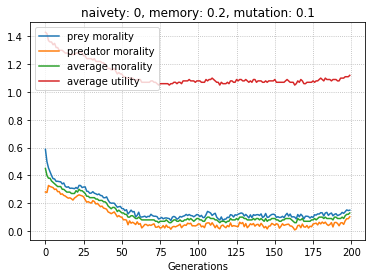

0.55 1.54
0.5 1.5
0.49 1.48
0.46 1.44
0.42 1.41
0.39 1.38
0.38 1.36
0.37 1.37
0.36 1.37
0.32 1.31
0.27 1.27
0.28 1.27
0.29 1.27
0.29 1.29
0.27 1.25
0.25 1.25
0.23 1.23
0.23 1.23
0.24 1.24
0.24 1.24
0.22 1.2
0.21 1.2
0.2 1.21
0.19 1.18
0.17 1.15
0.14 1.13
0.12 1.11
0.12 1.1
0.11 1.09
0.11 1.11
0.14 1.12
0.12 1.1
0.12 1.12
0.14 1.13
0.14 1.14
0.14 1.14
0.14 1.12
0.15 1.14
0.14 1.14
0.16 1.16
0.17 1.17
0.19 1.17
0.15 1.13
0.14 1.13
0.16 1.15
0.17 1.17
0.16 1.16
0.18 1.16
0.18 1.16
0.18 1.17
0.14 1.13
0.15 1.13
0.14 1.14
0.15 1.14
0.16 1.16
0.16 1.15
0.15 1.16
0.15 1.15
0.14 1.14
0.14 1.14
0.14 1.12
0.14 1.14
0.14 1.15
0.16 1.15
0.16 1.15
0.12 1.11
0.11 1.11
0.12 1.12
0.12 1.13
0.14 1.14
0.13 1.12
0.13 1.13
0.13 1.12
0.13 1.13
0.14 1.12
0.16 1.16
0.15 1.15
0.13 1.11
0.12 1.11
0.13 1.13
0.13 1.12
0.14 1.13
0.13 1.13
0.11 1.1
0.12 1.12
0.13 1.13
0.16 1.14
0.14 1.13
0.15 1.15
0.14 1.15
0.15 1.14
0.14 1.13
0.14 1.15
0.15 1.14
0.15 1.15
0.15 1.13
0.14 1.14
0.15 1.15
0.15 1.15
0.15 1.15
0.17 1.1

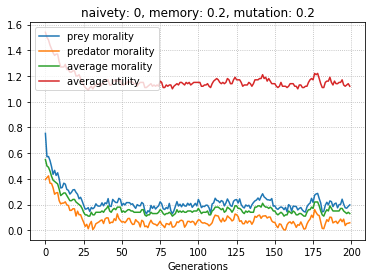

0.5 1.44
0.4 1.4
0.39 1.38
0.34 1.33
0.3 1.28
0.3 1.28
0.3 1.29
0.28 1.27
0.25 1.24
0.2 1.2
0.19 1.18
0.18 1.17
0.16 1.19
0.18 1.18
0.14 1.15
0.17 1.16
0.19 1.17
0.19 1.18
0.19 1.18
0.16 1.17
0.18 1.19
0.18 1.17
0.19 1.19
0.19 1.18
0.19 1.18
0.21 1.19
0.21 1.2
0.2 1.18
0.15 1.16
0.17 1.18
0.18 1.17
0.18 1.17
0.18 1.18
0.18 1.18
0.2 1.18
0.18 1.17
0.13 1.12
0.16 1.15
0.15 1.15
0.19 1.2
0.18 1.17
0.17 1.16
0.18 1.17
0.2 1.2
0.19 1.18
0.19 1.17
0.15 1.14
0.17 1.17
0.18 1.19
0.22 1.23
0.2 1.17
0.18 1.17
0.16 1.17
0.14 1.14
0.13 1.1
0.12 1.12
0.14 1.14
0.19 1.17
0.19 1.18
0.2 1.21
0.23 1.23
0.24 1.23
0.21 1.23
0.21 1.19
0.18 1.18
0.2 1.19
0.18 1.19
0.2 1.18
0.22 1.19
0.21 1.2
0.2 1.21
0.19 1.2
0.21 1.2
0.21 1.21
0.22 1.24
0.23 1.23
0.22 1.22
0.22 1.21
0.21 1.22
0.19 1.19
0.2 1.18
0.17 1.17
0.21 1.22
0.23 1.22
0.22 1.21
0.21 1.21
0.19 1.17
0.17 1.15
0.18 1.18
0.15 1.17
0.16 1.17
0.19 1.18
0.22 1.19
0.18 1.19
0.2 1.18
0.2 1.2
0.18 1.16
0.16 1.16
0.18 1.18
0.15 1.15
0.17 1.15
0.17 1.14
0.17 1.

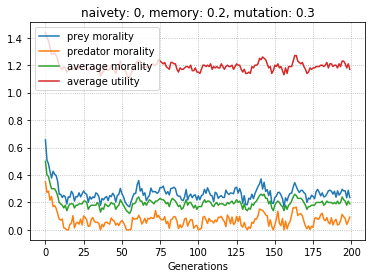

0.55 1.48
0.4 1.37
0.33 1.3
0.28 1.27
0.23 1.23
0.23 1.22
0.24 1.24
0.22 1.21
0.23 1.21
0.25 1.26
0.23 1.22
0.24 1.21
0.21 1.22
0.23 1.24
0.24 1.23
0.19 1.19
0.22 1.21
0.23 1.24
0.24 1.25
0.24 1.22
0.23 1.24
0.23 1.23
0.22 1.23
0.24 1.24
0.23 1.22
0.21 1.19
0.22 1.21
0.19 1.16
0.21 1.2
0.23 1.22
0.25 1.23
0.2 1.21
0.21 1.2
0.26 1.25
0.24 1.25
0.26 1.25
0.23 1.24
0.21 1.23
0.26 1.23
0.26 1.24
0.23 1.21
0.21 1.19
0.19 1.2
0.19 1.21
0.22 1.21
0.22 1.21
0.24 1.21
0.23 1.21
0.23 1.21
0.22 1.22
0.21 1.21
0.21 1.23
0.22 1.22
0.22 1.24
0.24 1.22
0.25 1.22
0.22 1.21
0.22 1.24
0.22 1.19
0.2 1.2
0.25 1.25
0.2 1.19
0.2 1.18
0.2 1.2
0.2 1.2
0.21 1.2
0.21 1.22
0.26 1.25
0.23 1.24
0.24 1.22
0.21 1.2
0.21 1.2
0.19 1.18
0.22 1.24
0.25 1.23
0.2 1.18
0.19 1.19
0.2 1.21
0.21 1.18
0.19 1.2
0.17 1.16
0.2 1.2
0.23 1.21
0.26 1.25
0.27 1.24
0.26 1.25
0.26 1.26
0.24 1.21
0.22 1.2
0.2 1.2
0.23 1.23
0.24 1.22
0.22 1.2
0.27 1.24
0.22 1.22
0.19 1.2
0.22 1.19
0.22 1.21
0.21 1.2
0.22 1.22
0.24 1.24
0.23 1.22
0.23 1.2

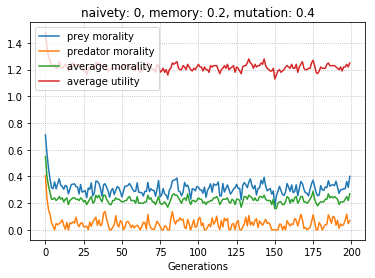

0.47 1.48
0.4 1.4
0.35 1.38
0.34 1.32
0.28 1.29
0.29 1.3
0.34 1.31
0.31 1.31
0.25 1.25
0.25 1.26
0.31 1.29
0.27 1.26
0.28 1.26
0.29 1.29
0.26 1.28
0.22 1.21
0.25 1.25
0.29 1.27
0.25 1.25
0.23 1.23
0.2 1.19
0.23 1.24
0.23 1.21
0.2 1.22
0.29 1.31
0.28 1.27
0.26 1.27
0.32 1.31
0.3 1.29
0.31 1.33
0.3 1.31
0.3 1.3
0.28 1.27
0.23 1.23
0.27 1.27
0.27 1.29
0.29 1.28
0.29 1.3
0.28 1.23
0.21 1.21
0.25 1.26
0.22 1.21
0.21 1.23
0.23 1.22
0.24 1.23
0.27 1.28
0.34 1.31
0.29 1.27
0.32 1.3
0.27 1.26
0.28 1.26
0.29 1.26
0.24 1.24
0.22 1.23
0.24 1.22
0.22 1.21
0.24 1.26
0.3 1.27
0.24 1.22
0.26 1.23
0.23 1.24
0.29 1.28
0.26 1.26
0.26 1.25
0.29 1.26
0.26 1.25
0.26 1.24
0.25 1.23
0.27 1.27
0.27 1.27
0.22 1.25
0.25 1.24
0.24 1.22
0.24 1.25
0.22 1.22
0.22 1.22
0.25 1.24
0.28 1.3
0.29 1.3
0.31 1.33
0.3 1.29
0.26 1.26
0.29 1.26
0.21 1.24
0.24 1.21
0.23 1.22
0.26 1.26
0.28 1.26
0.32 1.3
0.29 1.28
0.25 1.23
0.29 1.28
0.29 1.26
0.27 1.24
0.25 1.26
0.26 1.25
0.26 1.28
0.32 1.28
0.22 1.22
0.23 1.22
0.24 1.26
0.25 1

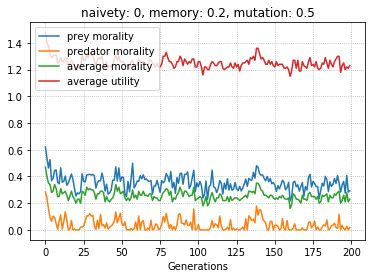

0.47 1.46
0.39 1.37
0.34 1.35
0.35 1.34
0.36 1.36
0.35 1.35
0.35 1.34
0.35 1.34
0.34 1.33
0.33 1.31
0.31 1.32
0.34 1.33
0.33 1.32
0.34 1.34
0.33 1.32
0.32 1.3
0.31 1.29
0.31 1.3
0.3 1.3
0.3 1.29
0.3 1.3
0.28 1.28
0.29 1.28
0.28 1.27
0.29 1.3
0.3 1.3
0.28 1.25
0.24 1.23
0.23 1.22
0.23 1.22
0.21 1.19
0.19 1.19
0.19 1.17
0.18 1.17
0.17 1.16
0.16 1.17
0.17 1.16
0.16 1.14
0.15 1.14
0.13 1.13
0.12 1.12
0.12 1.12
0.12 1.13
0.11 1.09
0.09 1.07
0.08 1.08
0.09 1.08
0.09 1.09
0.1 1.1
0.1 1.1
0.11 1.1
0.1 1.09
0.11 1.11
0.11 1.11
0.11 1.12
0.12 1.13
0.13 1.13
0.14 1.13
0.13 1.12
0.13 1.13
0.13 1.13
0.12 1.12
0.13 1.13
0.12 1.12
0.11 1.1
0.11 1.1
0.1 1.11
0.1 1.1
0.12 1.11
0.11 1.1
0.11 1.12
0.13 1.12
0.14 1.13
0.14 1.15
0.14 1.13
0.13 1.13
0.13 1.13
0.12 1.12
0.13 1.12
0.12 1.11
0.11 1.1
0.1 1.09
0.11 1.1
0.12 1.12
0.12 1.11
0.12 1.11
0.12 1.12
0.11 1.11
0.11 1.11
0.13 1.12
0.13 1.12
0.13 1.13
0.13 1.13
0.14 1.14
0.13 1.13
0.13 1.13
0.12 1.11
0.11 1.1
0.1 1.1
0.09 1.09
0.08 1.09
0.09 1.09
0.09 1.0

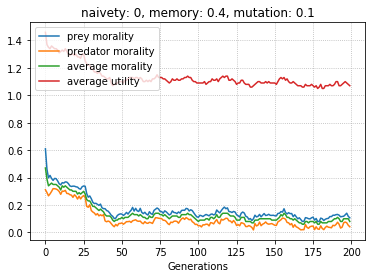

0.45 1.47
0.44 1.44
0.43 1.43
0.38 1.37
0.34 1.37
0.39 1.39
0.38 1.39
0.39 1.39
0.37 1.37
0.36 1.35
0.36 1.33
0.33 1.31
0.29 1.28
0.3 1.28
0.26 1.27
0.27 1.26
0.25 1.28
0.24 1.25
0.24 1.26
0.23 1.22
0.19 1.19
0.23 1.19
0.18 1.18
0.17 1.14
0.14 1.16
0.13 1.13
0.13 1.12
0.15 1.14
0.16 1.15
0.18 1.17
0.15 1.16
0.16 1.14
0.16 1.16
0.15 1.14
0.15 1.14
0.13 1.11
0.12 1.11
0.12 1.14
0.14 1.14
0.14 1.15
0.14 1.14
0.15 1.15
0.17 1.16
0.16 1.16
0.16 1.17
0.18 1.18
0.16 1.15
0.16 1.15
0.15 1.16
0.16 1.16
0.16 1.17
0.14 1.16
0.15 1.16
0.15 1.16
0.17 1.17
0.14 1.14
0.14 1.15
0.14 1.14
0.13 1.11
0.13 1.11
0.13 1.12
0.11 1.09
0.1 1.1
0.12 1.12
0.14 1.12
0.13 1.1
0.12 1.12
0.13 1.12
0.13 1.13
0.16 1.16
0.15 1.13
0.14 1.14
0.16 1.15
0.14 1.15
0.14 1.12
0.15 1.15
0.16 1.15
0.14 1.14
0.15 1.14
0.16 1.16
0.18 1.17
0.18 1.17
0.16 1.16
0.16 1.16
0.16 1.17
0.14 1.14
0.15 1.14
0.14 1.15
0.14 1.15
0.15 1.14
0.16 1.16
0.16 1.15
0.17 1.18
0.15 1.14
0.15 1.14
0.13 1.12
0.13 1.13
0.14 1.14
0.16 1.13
0.14 1.15
0.14

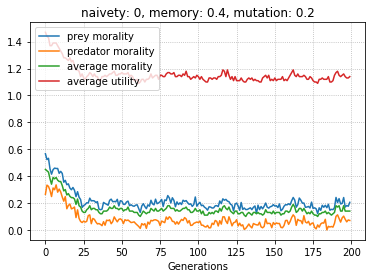

0.47 1.48
0.43 1.46
0.37 1.35
0.35 1.32
0.32 1.35
0.34 1.34
0.34 1.31
0.27 1.3
0.27 1.22
0.26 1.27
0.25 1.22
0.21 1.18
0.19 1.2
0.23 1.22
0.21 1.18
0.17 1.16
0.16 1.17
0.17 1.19
0.16 1.18
0.2 1.22
0.19 1.21
0.19 1.15
0.18 1.16
0.19 1.19
0.17 1.16
0.15 1.12
0.12 1.11
0.16 1.14
0.12 1.12
0.14 1.14
0.16 1.17
0.18 1.19
0.17 1.17
0.17 1.16
0.21 1.21
0.2 1.19
0.2 1.2
0.22 1.2
0.19 1.2
0.2 1.21
0.21 1.21
0.22 1.24
0.26 1.23
0.21 1.23
0.23 1.21
0.2 1.2
0.19 1.22
0.19 1.21
0.24 1.2
0.2 1.17
0.18 1.18
0.18 1.17
0.17 1.17
0.14 1.13
0.14 1.13
0.15 1.16
0.18 1.17
0.21 1.2
0.2 1.2
0.19 1.19
0.19 1.21
0.22 1.22
0.22 1.23
0.23 1.2
0.23 1.23
0.24 1.25
0.25 1.22
0.22 1.25
0.23 1.21
0.19 1.18
0.18 1.17
0.2 1.19
0.22 1.22
0.2 1.2
0.21 1.19
0.21 1.2
0.24 1.25
0.28 1.28
0.23 1.21
0.21 1.21
0.21 1.22
0.24 1.21
0.21 1.17
0.17 1.17
0.17 1.22
0.22 1.21
0.22 1.21
0.21 1.21
0.22 1.21
0.18 1.19
0.19 1.18
0.17 1.18
0.15 1.13
0.15 1.15
0.16 1.18
0.18 1.17
0.17 1.16
0.16 1.13
0.15 1.14
0.14 1.12
0.15 1.13
0.14 1.14
0

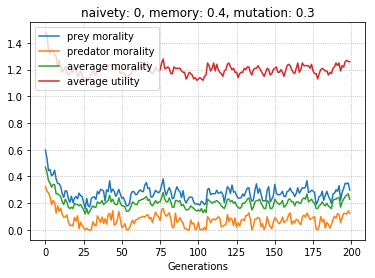

0.51 1.53
0.48 1.46
0.41 1.39
0.29 1.32
0.28 1.26
0.28 1.31
0.25 1.27
0.25 1.25
0.28 1.26
0.25 1.23
0.22 1.22
0.19 1.21
0.22 1.23
0.25 1.21
0.2 1.21
0.26 1.27
0.28 1.29
0.27 1.26
0.21 1.19
0.2 1.19
0.2 1.21
0.22 1.2
0.17 1.16
0.19 1.2
0.22 1.22
0.21 1.24
0.26 1.25
0.22 1.2
0.22 1.23
0.2 1.21
0.2 1.2
0.21 1.23
0.26 1.28
0.23 1.2
0.28 1.28
0.25 1.2
0.23 1.24
0.22 1.23
0.21 1.22
0.2 1.22
0.21 1.2
0.23 1.25
0.24 1.22
0.25 1.27
0.21 1.19
0.2 1.19
0.21 1.22
0.21 1.19
0.19 1.2
0.17 1.18
0.18 1.19
0.21 1.18
0.2 1.21
0.24 1.24
0.23 1.24
0.25 1.24
0.27 1.26
0.27 1.31
0.28 1.3
0.3 1.32
0.3 1.23
0.23 1.25
0.23 1.23
0.21 1.2
0.2 1.2
0.25 1.28
0.25 1.25
0.28 1.28
0.26 1.25
0.26 1.25
0.27 1.27
0.25 1.23
0.23 1.21
0.24 1.24
0.25 1.25
0.27 1.26
0.24 1.26
0.24 1.28
0.24 1.23
0.24 1.21
0.25 1.25
0.26 1.24
0.25 1.23
0.27 1.29
0.33 1.3
0.26 1.24
0.21 1.2
0.2 1.2
0.19 1.19
0.2 1.18
0.17 1.17
0.21 1.22
0.2 1.18
0.2 1.18
0.21 1.2
0.22 1.2
0.18 1.18
0.23 1.23
0.23 1.21
0.2 1.19
0.2 1.2
0.24 1.21
0.26 1.26
0.28

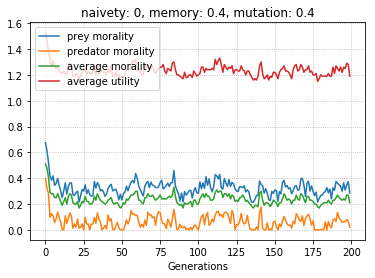

0.48 1.49
0.46 1.47
0.37 1.36
0.34 1.35
0.34 1.31
0.26 1.24
0.29 1.28
0.33 1.34
0.35 1.37
0.35 1.33
0.31 1.25
0.31 1.31
0.29 1.26
0.25 1.26
0.22 1.22
0.21 1.2
0.2 1.19
0.21 1.24
0.27 1.29
0.27 1.23
0.26 1.26
0.3 1.27
0.25 1.2
0.26 1.27
0.22 1.19
0.18 1.18
0.22 1.22
0.25 1.24
0.24 1.25
0.26 1.25
0.25 1.24
0.26 1.29
0.29 1.34
0.31 1.32
0.34 1.38
0.36 1.32
0.29 1.3
0.29 1.3
0.34 1.3
0.32 1.34
0.34 1.37
0.36 1.32
0.28 1.31
0.31 1.29
0.23 1.21
0.19 1.16
0.21 1.23
0.24 1.28
0.31 1.3
0.31 1.3
0.29 1.3
0.3 1.32
0.31 1.29
0.29 1.29
0.32 1.32
0.33 1.29
0.27 1.3
0.28 1.26
0.27 1.28
0.28 1.31
0.29 1.3
0.29 1.3
0.34 1.35
0.29 1.28
0.29 1.26
0.23 1.23
0.23 1.22
0.22 1.22
0.26 1.24
0.27 1.25
0.28 1.33
0.32 1.37
0.3 1.29
0.27 1.24
0.27 1.23
0.25 1.29
0.2 1.25
0.28 1.3
0.27 1.27
0.29 1.24
0.26 1.26
0.24 1.25
0.29 1.36
0.34 1.38
0.3 1.31
0.29 1.23
0.3 1.31
0.33 1.34
0.4 1.41
0.4 1.39
0.33 1.3
0.32 1.27
0.27 1.28
0.26 1.22
0.26 1.24
0.23 1.24
0.23 1.23
0.23 1.21
0.18 1.19
0.27 1.26
0.28 1.28
0.28 1.26
0.

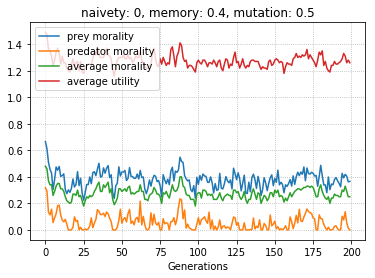

0.49 1.56
0.52 1.5
0.48 1.46
0.46 1.46
0.46 1.45
0.45 1.45
0.45 1.44
0.42 1.39
0.39 1.4
0.41 1.41
0.41 1.41
0.42 1.42
0.42 1.41
0.41 1.4
0.41 1.41
0.42 1.41
0.39 1.38
0.39 1.38
0.37 1.37
0.37 1.37
0.37 1.39
0.4 1.4
0.41 1.4
0.41 1.39
0.38 1.38
0.36 1.35
0.36 1.35
0.36 1.36
0.35 1.33
0.34 1.34
0.35 1.34
0.35 1.34
0.34 1.33
0.33 1.32
0.33 1.33
0.31 1.31
0.29 1.27
0.28 1.27
0.27 1.27
0.27 1.27
0.28 1.27
0.27 1.28
0.27 1.26
0.28 1.28
0.27 1.28
0.28 1.29
0.29 1.31
0.3 1.29
0.29 1.28
0.28 1.29
0.29 1.29
0.28 1.26
0.26 1.26
0.26 1.23
0.24 1.24
0.24 1.23
0.23 1.21
0.21 1.19
0.2 1.18
0.19 1.19
0.21 1.2
0.2 1.2
0.2 1.19
0.19 1.19
0.17 1.17
0.18 1.18
0.2 1.19
0.19 1.18
0.17 1.15
0.16 1.15
0.15 1.15
0.15 1.14
0.13 1.13
0.12 1.1
0.12 1.1
0.1 1.1
0.11 1.12
0.1 1.09
0.09 1.08
0.08 1.08
0.08 1.08
0.08 1.07
0.08 1.06
0.07 1.06
0.09 1.08
0.09 1.08
0.09 1.09
0.09 1.09
0.09 1.08
0.09 1.09
0.09 1.08
0.09 1.1
0.11 1.11
0.12 1.12
0.13 1.11
0.12 1.12
0.12 1.12
0.11 1.11
0.11 1.09
0.09 1.09
0.1 1.09
0.09 1.1
0

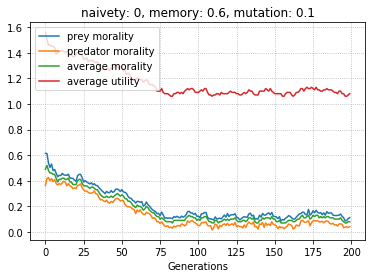

0.51 1.48
0.45 1.47
0.44 1.41
0.38 1.38
0.39 1.38
0.36 1.35
0.35 1.32
0.3 1.29
0.3 1.32
0.3 1.33
0.33 1.32
0.3 1.28
0.26 1.26
0.24 1.24
0.22 1.21
0.21 1.22
0.24 1.26
0.23 1.22
0.23 1.2
0.2 1.21
0.22 1.22
0.19 1.19
0.17 1.15
0.18 1.19
0.19 1.17
0.15 1.16
0.14 1.13
0.12 1.12
0.12 1.12
0.13 1.12
0.15 1.17
0.17 1.15
0.17 1.16
0.17 1.19
0.17 1.16
0.16 1.14
0.14 1.18
0.15 1.13
0.14 1.12
0.12 1.1
0.12 1.12
0.12 1.11
0.14 1.14
0.14 1.16
0.17 1.15
0.15 1.13
0.14 1.13
0.13 1.17
0.14 1.14
0.13 1.13
0.14 1.12
0.12 1.13
0.13 1.12
0.13 1.12
0.11 1.1
0.12 1.1
0.12 1.13
0.14 1.14
0.17 1.15
0.16 1.2
0.2 1.19
0.19 1.21
0.2 1.18
0.19 1.17
0.17 1.15
0.16 1.16
0.19 1.21
0.2 1.19
0.18 1.15
0.14 1.12
0.12 1.1
0.13 1.11
0.13 1.12
0.1 1.07
0.1 1.11
0.15 1.14
0.15 1.15
0.12 1.1
0.13 1.14
0.14 1.12
0.15 1.14
0.14 1.15
0.16 1.15
0.14 1.12
0.11 1.13
0.13 1.12
0.14 1.15
0.16 1.14
0.16 1.14
0.15 1.16
0.17 1.16
0.17 1.16
0.15 1.13
0.13 1.1
0.11 1.08
0.11 1.09
0.09 1.1
0.11 1.1
0.11 1.1
0.1 1.11
0.14 1.15
0.15 1.13
0.

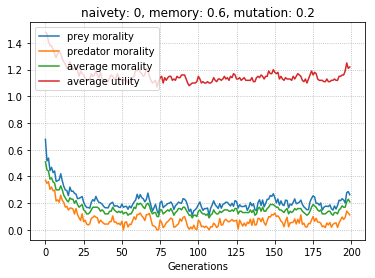

0.46 1.45
0.4 1.36
0.26 1.26
0.28 1.33
0.33 1.32
0.25 1.25
0.25 1.21
0.2 1.2
0.21 1.17
0.19 1.17
0.17 1.15
0.15 1.15
0.19 1.18
0.18 1.17
0.17 1.19
0.17 1.18
0.21 1.24
0.25 1.27
0.26 1.25
0.27 1.25
0.25 1.22
0.23 1.2
0.23 1.28
0.27 1.22
0.2 1.19
0.17 1.14
0.16 1.16
0.17 1.15
0.15 1.13
0.16 1.15
0.19 1.17
0.16 1.14
0.17 1.16
0.19 1.19
0.2 1.22
0.21 1.22
0.24 1.25
0.28 1.29
0.28 1.28
0.27 1.27
0.23 1.22
0.2 1.18
0.21 1.17
0.18 1.2
0.22 1.25
0.25 1.21
0.24 1.23
0.24 1.26
0.25 1.29
0.26 1.24
0.24 1.23
0.2 1.18
0.19 1.19
0.2 1.19
0.18 1.15
0.17 1.18
0.2 1.2
0.2 1.22
0.21 1.2
0.17 1.14
0.17 1.19
0.17 1.16
0.16 1.13
0.17 1.19
0.22 1.2
0.24 1.27
0.26 1.24
0.22 1.21
0.21 1.2
0.2 1.18
0.17 1.17
0.17 1.17
0.21 1.18
0.17 1.2
0.19 1.18
0.17 1.19
0.19 1.2
0.18 1.16
0.17 1.15
0.15 1.12
0.15 1.13
0.14 1.11
0.15 1.12
0.14 1.12
0.16 1.17
0.17 1.17
0.18 1.17
0.19 1.2
0.21 1.22
0.21 1.19
0.21 1.19
0.19 1.2
0.2 1.19
0.22 1.23
0.22 1.17
0.14 1.12
0.14 1.15
0.18 1.19
0.2 1.19
0.2 1.19
0.21 1.21
0.21 1.23
0.23

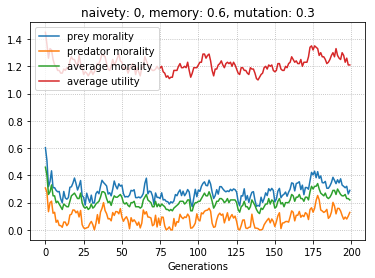

0.49 1.5
0.45 1.42
0.41 1.4
0.34 1.33
0.35 1.4
0.37 1.41
0.34 1.32
0.29 1.34
0.3 1.27
0.27 1.28
0.31 1.32
0.31 1.35
0.29 1.31
0.28 1.27
0.3 1.32
0.31 1.29
0.27 1.25
0.24 1.23
0.21 1.2
0.22 1.25
0.28 1.27
0.28 1.29
0.3 1.33
0.36 1.36
0.3 1.3
0.26 1.23
0.24 1.21
0.21 1.17
0.19 1.18
0.19 1.19
0.2 1.22
0.21 1.18
0.2 1.17
0.18 1.21
0.19 1.19
0.2 1.16
0.23 1.21
0.25 1.3
0.27 1.24
0.21 1.24
0.23 1.22
0.19 1.18
0.18 1.15
0.19 1.2
0.21 1.2
0.19 1.22
0.21 1.2
0.24 1.21
0.2 1.2
0.24 1.23
0.25 1.26
0.22 1.22
0.22 1.22
0.23 1.21
0.26 1.27
0.23 1.23
0.22 1.21
0.25 1.32
0.33 1.29
0.28 1.26
0.21 1.21
0.2 1.2
0.22 1.25
0.26 1.25
0.23 1.2
0.23 1.19
0.2 1.17
0.21 1.21
0.22 1.2
0.24 1.22
0.25 1.28
0.24 1.2
0.22 1.26
0.23 1.22
0.23 1.23
0.22 1.18
0.21 1.2
0.26 1.29
0.27 1.27
0.27 1.27
0.23 1.21
0.21 1.21
0.23 1.2
0.22 1.22
0.24 1.21
0.23 1.24
0.27 1.25
0.28 1.26
0.21 1.24
0.23 1.24
0.24 1.21
0.22 1.2
0.23 1.19
0.21 1.27
0.28 1.35
0.37 1.36
0.32 1.34
0.31 1.28
0.25 1.23
0.26 1.24
0.23 1.23
0.28 1.28
0.27 1.

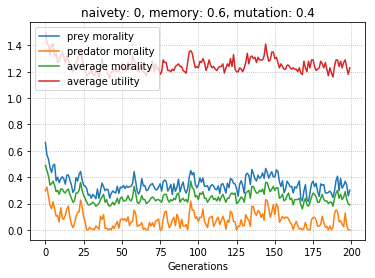

0.47 1.49
0.45 1.45
0.41 1.42
0.36 1.31
0.27 1.27
0.32 1.33
0.38 1.32
0.3 1.31
0.28 1.23
0.24 1.19
0.25 1.25
0.28 1.31
0.31 1.34
0.3 1.28
0.3 1.31
0.28 1.3
0.31 1.28
0.26 1.28
0.29 1.32
0.31 1.31
0.26 1.26
0.28 1.26
0.3 1.32
0.35 1.39
0.37 1.33
0.29 1.34
0.34 1.29
0.27 1.35
0.36 1.35
0.34 1.34
0.32 1.27
0.23 1.27
0.29 1.31
0.32 1.33
0.33 1.35
0.34 1.34
0.34 1.42
0.36 1.36
0.33 1.36
0.35 1.34
0.33 1.37
0.33 1.39
0.33 1.37
0.33 1.3
0.28 1.26
0.27 1.28
0.29 1.31
0.31 1.33
0.32 1.34
0.3 1.25
0.26 1.24
0.23 1.18
0.22 1.2
0.25 1.21
0.26 1.24
0.3 1.32
0.31 1.28
0.23 1.27
0.28 1.34
0.39 1.46
0.41 1.41
0.33 1.28
0.36 1.37
0.34 1.35
0.28 1.26
0.26 1.23
0.21 1.19
0.19 1.18
0.23 1.19
0.28 1.3
0.33 1.34
0.33 1.3
0.25 1.26
0.28 1.25
0.27 1.24
0.21 1.23
0.25 1.25
0.23 1.26
0.3 1.33
0.28 1.26
0.29 1.3
0.26 1.28
0.24 1.25
0.32 1.32
0.27 1.25
0.29 1.29
0.34 1.32
0.33 1.35
0.36 1.39
0.32 1.29
0.3 1.34
0.3 1.31
0.28 1.27
0.28 1.3
0.27 1.32
0.29 1.36
0.29 1.28
0.29 1.26
0.26 1.29
0.3 1.29
0.27 1.26
0.33 1.

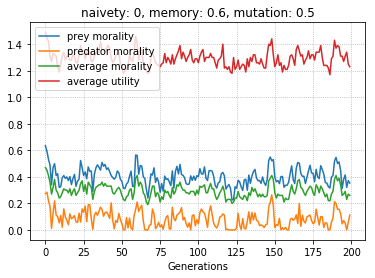

0.5 1.56
0.5 1.48
0.46 1.46
0.45 1.46
0.46 1.46
0.46 1.44
0.43 1.41
0.43 1.42
0.41 1.41
0.4 1.4
0.4 1.41
0.4 1.38
0.39 1.37
0.38 1.39
0.39 1.39
0.39 1.38
0.38 1.37
0.37 1.36
0.36 1.36
0.36 1.35
0.36 1.35
0.36 1.35
0.35 1.36
0.35 1.35
0.34 1.32
0.33 1.33
0.33 1.31
0.32 1.29
0.3 1.3
0.3 1.29
0.3 1.29
0.3 1.3
0.29 1.3
0.3 1.29
0.29 1.3
0.3 1.29
0.3 1.31
0.31 1.29
0.3 1.29
0.3 1.29
0.29 1.28
0.26 1.25
0.26 1.24
0.24 1.23
0.23 1.22
0.22 1.21
0.21 1.22
0.21 1.21
0.2 1.21
0.2 1.21
0.22 1.21
0.22 1.2
0.18 1.16
0.15 1.15
0.13 1.14
0.14 1.12
0.12 1.12
0.12 1.1
0.11 1.1
0.11 1.12
0.12 1.13
0.13 1.12
0.11 1.11
0.1 1.11
0.11 1.1
0.09 1.08
0.1 1.11
0.1 1.11
0.1 1.1
0.11 1.1
0.11 1.11
0.12 1.11
0.11 1.1
0.1 1.08
0.09 1.09
0.09 1.08
0.09 1.08
0.08 1.07
0.09 1.08
0.08 1.07
0.07 1.06
0.07 1.05
0.07 1.07
0.07 1.05
0.08 1.08
0.08 1.06
0.06 1.06
0.08 1.07
0.08 1.07
0.07 1.06
0.08 1.06
0.07 1.05
0.06 1.07
0.07 1.07
0.08 1.08
0.08 1.08
0.08 1.06
0.06 1.04
0.07 1.05
0.06 1.07
0.07 1.08
0.1 1.08
0.09 1.08
0.09

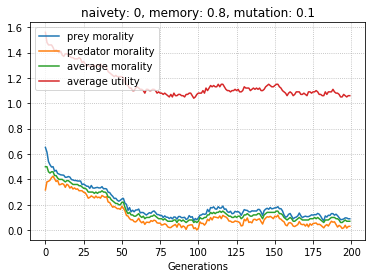

0.51 1.52
0.46 1.45
0.41 1.39
0.38 1.43
0.41 1.44
0.4 1.41
0.38 1.34
0.32 1.31
0.29 1.29
0.3 1.31
0.29 1.27
0.27 1.28
0.28 1.27
0.28 1.27
0.23 1.23
0.22 1.22
0.2 1.21
0.22 1.23
0.23 1.22
0.21 1.2
0.21 1.2
0.19 1.18
0.18 1.19
0.17 1.19
0.19 1.19
0.15 1.15
0.15 1.13
0.15 1.15
0.15 1.14
0.14 1.16
0.15 1.15
0.15 1.17
0.18 1.2
0.19 1.18
0.18 1.17
0.19 1.19
0.17 1.21
0.21 1.24
0.23 1.25
0.25 1.25
0.25 1.23
0.21 1.19
0.17 1.14
0.15 1.14
0.13 1.13
0.13 1.13
0.14 1.13
0.13 1.14
0.16 1.16
0.17 1.17
0.18 1.17
0.16 1.17
0.17 1.13
0.15 1.14
0.15 1.14
0.14 1.13
0.16 1.15
0.15 1.15
0.15 1.15
0.17 1.17
0.17 1.16
0.19 1.19
0.16 1.17
0.16 1.18
0.17 1.17
0.17 1.17
0.19 1.17
0.17 1.16
0.15 1.16
0.16 1.15
0.14 1.14
0.13 1.12
0.12 1.14
0.16 1.16
0.19 1.17
0.15 1.14
0.15 1.15
0.14 1.18
0.19 1.19
0.2 1.19
0.18 1.18
0.18 1.17
0.15 1.14
0.14 1.14
0.16 1.15
0.16 1.18
0.19 1.18
0.15 1.17
0.15 1.14
0.15 1.16
0.15 1.15
0.18 1.17
0.17 1.16
0.13 1.12
0.13 1.14
0.15 1.13
0.12 1.1
0.1 1.08
0.09 1.09
0.09 1.08
0.1 1.1
0

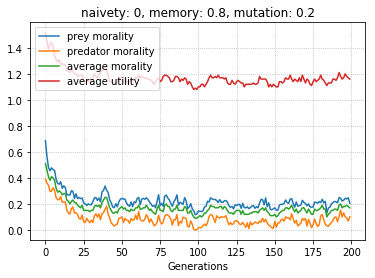

0.49 1.49
0.42 1.43
0.38 1.43
0.4 1.44
0.39 1.43
0.36 1.39
0.35 1.33
0.3 1.31
0.27 1.25
0.26 1.25
0.26 1.27
0.25 1.25
0.25 1.24
0.24 1.23
0.24 1.25
0.23 1.25
0.27 1.31
0.27 1.25
0.25 1.23
0.23 1.21
0.15 1.13
0.18 1.17
0.21 1.23
0.23 1.26
0.23 1.24
0.26 1.32
0.27 1.34
0.33 1.31
0.3 1.33
0.36 1.41
0.36 1.4
0.42 1.45
0.43 1.43
0.37 1.38
0.35 1.34
0.38 1.36
0.34 1.37
0.35 1.33
0.31 1.28
0.3 1.27
0.28 1.27
0.28 1.32
0.31 1.28
0.24 1.27
0.3 1.26
0.24 1.23
0.21 1.24
0.24 1.24
0.26 1.22
0.23 1.28
0.26 1.29
0.28 1.26
0.29 1.31
0.29 1.26
0.28 1.3
0.29 1.3
0.3 1.31
0.31 1.35
0.31 1.29
0.3 1.3
0.27 1.31
0.33 1.36
0.33 1.33
0.34 1.35
0.36 1.37
0.32 1.29
0.32 1.36
0.33 1.31
0.27 1.24
0.2 1.17
0.18 1.19
0.16 1.18
0.2 1.18
0.18 1.21
0.22 1.21
0.17 1.14
0.17 1.21
0.2 1.16
0.15 1.17
0.2 1.19
0.2 1.18
0.17 1.17
0.18 1.16
0.18 1.22
0.21 1.22
0.21 1.2
0.2 1.19
0.2 1.21
0.21 1.24
0.25 1.29
0.29 1.32
0.3 1.3
0.26 1.26
0.25 1.23
0.25 1.26
0.27 1.3
0.27 1.26
0.26 1.26
0.24 1.24
0.24 1.22
0.25 1.27
0.23 1.25
0.

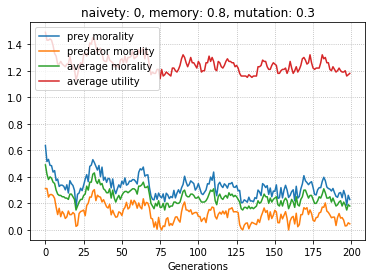

0.5 1.45
0.42 1.38
0.4 1.43
0.4 1.41
0.39 1.45
0.43 1.42
0.39 1.36
0.34 1.34
0.32 1.33
0.3 1.33
0.33 1.33
0.31 1.32
0.33 1.3
0.32 1.31
0.35 1.32
0.26 1.3
0.28 1.29
0.3 1.34
0.31 1.37
0.37 1.34
0.32 1.42
0.4 1.35
0.31 1.33
0.31 1.29
0.27 1.31
0.31 1.31
0.33 1.35
0.34 1.36
0.37 1.37
0.37 1.36
0.34 1.35
0.31 1.28
0.34 1.41
0.4 1.42
0.41 1.41
0.39 1.42
0.38 1.36
0.3 1.34
0.28 1.3
0.3 1.33
0.31 1.28
0.3 1.35
0.32 1.29
0.32 1.28
0.27 1.28
0.24 1.24
0.24 1.26
0.25 1.26
0.21 1.21
0.24 1.31
0.33 1.31
0.32 1.35
0.35 1.33
0.29 1.29
0.26 1.34
0.35 1.37
0.37 1.4
0.35 1.36
0.38 1.37
0.31 1.37
0.38 1.34
0.36 1.31
0.26 1.26
0.27 1.33
0.37 1.36
0.38 1.36
0.34 1.31
0.33 1.34
0.28 1.34
0.29 1.27
0.25 1.23
0.19 1.22
0.24 1.23
0.28 1.28
0.26 1.27
0.24 1.21
0.22 1.18
0.2 1.21
0.19 1.16
0.19 1.18
0.2 1.19
0.19 1.21
0.22 1.21
0.25 1.26
0.24 1.24
0.26 1.27
0.28 1.25
0.25 1.24
0.26 1.24
0.28 1.25
0.25 1.32
0.31 1.31
0.29 1.26
0.25 1.25
0.25 1.26
0.26 1.25
0.23 1.2
0.2 1.18
0.19 1.19
0.19 1.23
0.25 1.23
0.27 1.2

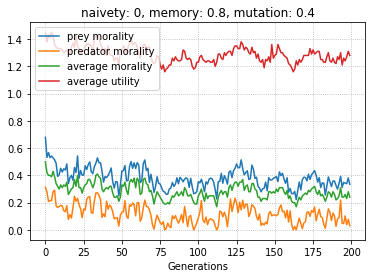

0.54 1.58
0.51 1.49
0.43 1.38
0.32 1.32
0.35 1.34
0.3 1.35
0.27 1.24
0.25 1.26
0.28 1.26
0.25 1.28
0.25 1.26
0.23 1.26
0.26 1.33
0.34 1.41
0.34 1.32
0.31 1.27
0.29 1.33
0.33 1.33
0.38 1.35
0.35 1.33
0.32 1.37
0.29 1.29
0.3 1.31
0.28 1.27
0.26 1.28
0.3 1.34
0.34 1.29
0.24 1.32
0.25 1.28
0.32 1.31
0.34 1.42
0.37 1.4
0.37 1.34
0.29 1.29
0.28 1.29
0.25 1.26
0.26 1.24
0.27 1.29
0.31 1.32
0.29 1.34
0.33 1.33
0.34 1.44
0.37 1.38
0.4 1.39
0.37 1.4
0.36 1.39
0.36 1.41
0.37 1.4
0.37 1.38
0.36 1.4
0.35 1.35
0.3 1.26
0.26 1.31
0.35 1.37
0.41 1.41
0.4 1.4
0.36 1.39
0.38 1.38
0.35 1.4
0.36 1.3
0.31 1.31
0.33 1.32
0.33 1.31
0.28 1.24
0.25 1.23
0.25 1.29
0.31 1.34
0.35 1.33
0.33 1.33
0.32 1.3
0.27 1.24
0.25 1.2
0.2 1.18
0.25 1.3
0.36 1.33
0.28 1.28
0.31 1.39
0.37 1.39
0.37 1.34
0.3 1.38
0.4 1.39
0.35 1.35
0.38 1.37
0.37 1.37
0.34 1.31
0.32 1.32
0.34 1.31
0.31 1.31
0.32 1.34
0.4 1.38
0.31 1.35
0.32 1.35
0.33 1.3
0.26 1.3
0.34 1.4
0.41 1.42
0.4 1.44
0.47 1.44
0.4 1.38
0.35 1.37
0.35 1.29
0.28 1.29
0.34 

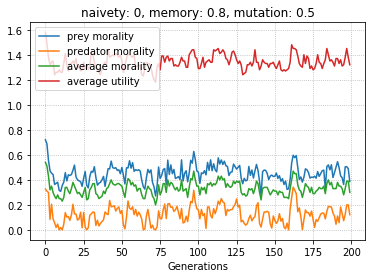

0.48 1.47
0.45 1.44
0.42 1.41
0.41 1.4
0.4 1.39
0.39 1.38
0.39 1.38
0.38 1.37
0.39 1.38
0.38 1.38
0.39 1.38
0.38 1.38
0.37 1.36
0.35 1.35
0.34 1.34
0.34 1.33
0.32 1.3
0.31 1.29
0.31 1.3
0.3 1.3
0.29 1.28
0.28 1.27
0.28 1.29
0.29 1.28
0.29 1.27
0.28 1.28
0.28 1.27
0.27 1.27
0.28 1.27
0.28 1.28
0.28 1.27
0.28 1.28
0.27 1.27
0.29 1.29
0.28 1.26
0.26 1.25
0.25 1.25
0.25 1.25
0.24 1.23
0.25 1.24
0.26 1.25
0.25 1.25
0.26 1.26
0.24 1.21
0.22 1.21
0.2 1.19
0.18 1.17
0.18 1.17
0.16 1.16
0.16 1.15
0.17 1.16
0.15 1.14
0.15 1.13
0.14 1.12
0.13 1.11
0.12 1.1
0.12 1.09
0.12 1.1
0.12 1.11
0.1 1.08
0.08 1.07
0.08 1.06
0.08 1.07
0.07 1.05
0.07 1.05
0.08 1.05
0.07 1.06
0.08 1.05
0.06 1.05
0.07 1.05
0.06 1.05
0.05 1.05
0.07 1.06
0.06 1.04
0.07 1.05
0.07 1.06
0.07 1.06
0.07 1.06
0.06 1.06
0.06 1.04
0.05 1.03
0.05 1.05
0.05 1.05
0.06 1.05
0.07 1.04
0.06 1.04
0.06 1.04
0.06 1.05
0.06 1.05
0.05 1.04
0.06 1.04
0.05 1.04
0.05 1.05
0.06 1.05
0.06 1.05
0.06 1.04
0.05 1.04
0.05 1.04
0.06 1.04
0.06 1.06
0.05 1.04


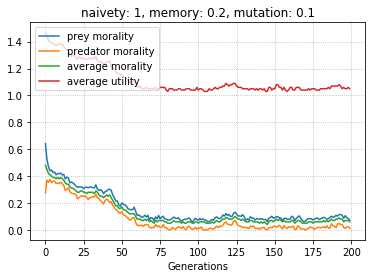

0.49 1.49
0.47 1.46
0.44 1.43
0.38 1.37
0.33 1.33
0.31 1.3
0.31 1.29
0.29 1.28
0.26 1.24
0.23 1.23
0.24 1.24
0.26 1.23
0.27 1.25
0.25 1.23
0.21 1.18
0.2 1.18
0.19 1.17
0.16 1.13
0.16 1.14
0.16 1.14
0.16 1.15
0.17 1.15
0.17 1.16
0.17 1.14
0.16 1.14
0.15 1.14
0.15 1.14
0.15 1.12
0.15 1.12
0.14 1.11
0.12 1.08
0.11 1.08
0.11 1.09
0.11 1.08
0.1 1.08
0.09 1.06
0.11 1.08
0.1 1.07
0.09 1.09
0.11 1.08
0.11 1.1
0.14 1.12
0.14 1.12
0.12 1.13
0.14 1.13
0.13 1.12
0.13 1.13
0.11 1.11
0.1 1.08
0.11 1.09
0.1 1.08
0.12 1.11
0.12 1.1
0.14 1.11
0.11 1.09
0.1 1.08
0.1 1.07
0.12 1.11
0.11 1.11
0.12 1.1
0.12 1.09
0.11 1.09
0.1 1.08
0.11 1.08
0.11 1.09
0.1 1.09
0.09 1.08
0.11 1.11
0.11 1.09
0.09 1.06
0.07 1.06
0.08 1.07
0.11 1.11
0.11 1.12
0.14 1.11
0.14 1.11
0.11 1.08
0.13 1.1
0.11 1.11
0.12 1.09
0.13 1.12
0.14 1.13
0.15 1.13
0.14 1.12
0.12 1.1
0.1 1.08
0.09 1.06
0.09 1.08
0.1 1.09
0.11 1.08
0.12 1.09
0.1 1.09
0.12 1.11
0.13 1.12
0.14 1.12
0.15 1.13
0.14 1.13
0.14 1.12
0.15 1.13
0.14 1.13
0.14 1.13
0.14 1.1

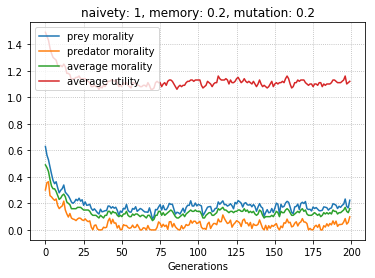

0.47 1.44
0.42 1.41
0.41 1.39
0.36 1.32
0.33 1.34
0.32 1.28
0.26 1.24
0.23 1.2
0.21 1.2
0.22 1.2
0.21 1.17
0.19 1.19
0.2 1.17
0.19 1.16
0.18 1.2
0.2 1.19
0.18 1.17
0.19 1.18
0.21 1.2
0.2 1.19
0.19 1.17
0.18 1.15
0.15 1.11
0.15 1.13
0.18 1.15
0.17 1.15
0.18 1.14
0.17 1.13
0.16 1.13
0.17 1.13
0.15 1.13
0.16 1.13
0.16 1.15
0.16 1.14
0.16 1.14
0.17 1.16
0.18 1.18
0.21 1.18
0.19 1.16
0.16 1.15
0.17 1.15
0.19 1.16
0.19 1.18
0.19 1.18
0.21 1.21
0.23 1.2
0.22 1.18
0.19 1.17
0.18 1.15
0.18 1.14
0.16 1.16
0.16 1.16
0.19 1.17
0.2 1.18
0.17 1.18
0.16 1.12
0.18 1.13
0.18 1.16
0.17 1.14
0.19 1.19
0.2 1.19
0.21 1.18
0.2 1.2
0.23 1.22
0.27 1.24
0.24 1.21
0.23 1.22
0.24 1.23
0.2 1.17
0.21 1.16
0.19 1.16
0.18 1.14
0.18 1.18
0.17 1.15
0.17 1.17
0.18 1.13
0.18 1.14
0.17 1.14
0.18 1.15
0.17 1.15
0.22 1.23
0.23 1.2
0.21 1.21
0.2 1.18
0.19 1.16
0.18 1.14
0.18 1.16
0.17 1.14
0.17 1.14
0.18 1.16
0.19 1.18
0.2 1.18
0.21 1.18
0.18 1.18
0.17 1.16
0.18 1.14
0.2 1.17
0.18 1.16
0.19 1.17
0.2 1.19
0.23 1.21
0.22 1.18

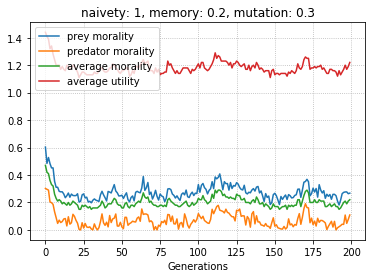

0.55 1.55
0.53 1.52
0.52 1.5
0.49 1.44
0.48 1.48
0.43 1.41
0.39 1.37
0.32 1.3
0.32 1.27
0.26 1.25
0.28 1.26
0.29 1.27
0.29 1.27
0.29 1.28
0.27 1.26
0.25 1.23
0.22 1.18
0.23 1.26
0.28 1.25
0.25 1.21
0.24 1.2
0.26 1.25
0.23 1.22
0.2 1.18
0.19 1.15
0.22 1.2
0.25 1.24
0.25 1.21
0.24 1.21
0.26 1.22
0.23 1.25
0.23 1.21
0.24 1.19
0.22 1.2
0.24 1.2
0.24 1.22
0.24 1.21
0.24 1.22
0.21 1.17
0.26 1.24
0.28 1.25
0.27 1.26
0.26 1.22
0.23 1.2
0.23 1.2
0.19 1.17
0.17 1.14
0.16 1.16
0.19 1.18
0.2 1.16
0.22 1.2
0.18 1.16
0.24 1.2
0.21 1.21
0.27 1.27
0.3 1.27
0.3 1.28
0.32 1.3
0.31 1.27
0.3 1.26
0.29 1.28
0.35 1.33
0.31 1.29
0.32 1.28
0.28 1.25
0.28 1.23
0.3 1.27
0.26 1.24
0.28 1.26
0.28 1.28
0.31 1.28
0.22 1.19
0.24 1.22
0.25 1.22
0.29 1.27
0.29 1.28
0.24 1.23
0.27 1.24
0.25 1.23
0.28 1.25
0.29 1.29
0.28 1.25
0.25 1.21
0.23 1.17
0.18 1.17
0.2 1.16
0.19 1.2
0.22 1.17
0.25 1.24
0.28 1.24
0.31 1.28
0.29 1.25
0.26 1.22
0.27 1.24
0.22 1.2
0.21 1.21
0.21 1.18
0.22 1.2
0.24 1.2
0.21 1.21
0.25 1.2
0.21 1.19
0.2

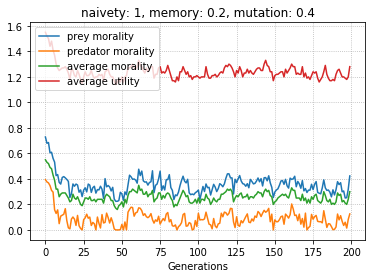

0.5 1.49
0.52 1.46
0.51 1.48
0.47 1.44
0.45 1.41
0.36 1.34
0.35 1.29
0.3 1.26
0.31 1.28
0.32 1.28
0.32 1.28
0.3 1.26
0.33 1.28
0.28 1.24
0.3 1.29
0.27 1.23
0.35 1.32
0.3 1.29
0.32 1.29
0.27 1.25
0.29 1.24
0.29 1.29
0.33 1.28
0.33 1.29
0.3 1.27
0.29 1.24
0.25 1.23
0.29 1.25
0.25 1.25
0.26 1.21
0.26 1.21
0.28 1.25
0.26 1.23
0.25 1.2
0.21 1.17
0.24 1.2
0.27 1.24
0.25 1.21
0.29 1.24
0.3 1.23
0.28 1.26
0.32 1.28
0.32 1.3
0.29 1.26
0.31 1.3
0.29 1.26
0.3 1.3
0.32 1.28
0.29 1.28
0.31 1.28
0.3 1.26
0.32 1.27
0.27 1.23
0.28 1.26
0.27 1.23
0.27 1.24
0.26 1.23
0.27 1.27
0.29 1.27
0.29 1.26
0.35 1.33
0.37 1.35
0.34 1.3
0.36 1.33
0.34 1.32
0.3 1.3
0.3 1.25
0.26 1.22
0.26 1.22
0.26 1.24
0.27 1.26
0.29 1.27
0.31 1.29
0.28 1.24
0.24 1.24
0.27 1.24
0.25 1.24
0.29 1.26
0.3 1.31
0.31 1.28
0.32 1.3
0.3 1.25
0.28 1.25
0.28 1.24
0.3 1.29
0.27 1.22
0.24 1.22
0.31 1.28
0.34 1.32
0.34 1.3
0.37 1.34
0.37 1.33
0.28 1.26
0.29 1.25
0.25 1.23
0.22 1.19
0.23 1.22
0.3 1.28
0.28 1.3
0.31 1.3
0.37 1.37
0.35 1.31
0.31 1

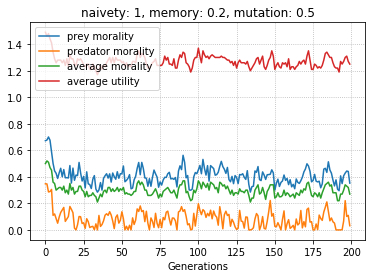

0.45 1.47
0.42 1.44
0.41 1.41
0.42 1.43
0.44 1.45
0.44 1.43
0.43 1.41
0.41 1.4
0.41 1.41
0.43 1.43
0.43 1.42
0.43 1.44
0.43 1.43
0.45 1.45
0.44 1.45
0.45 1.44
0.44 1.44
0.45 1.44
0.45 1.44
0.45 1.44
0.45 1.45
0.46 1.46
0.45 1.45
0.45 1.45
0.45 1.46
0.45 1.45
0.44 1.45
0.42 1.41
0.43 1.43
0.43 1.43
0.44 1.44
0.44 1.45
0.45 1.44
0.44 1.44
0.44 1.43
0.44 1.43
0.43 1.43
0.41 1.4
0.41 1.41
0.42 1.43
0.45 1.44
0.45 1.43
0.44 1.44
0.43 1.43
0.44 1.43
0.43 1.43
0.44 1.44
0.43 1.43
0.43 1.43
0.45 1.44
0.44 1.42
0.43 1.42
0.42 1.42
0.42 1.4
0.41 1.4
0.41 1.42
0.42 1.42
0.41 1.41
0.41 1.41
0.42 1.41
0.41 1.42
0.43 1.43
0.44 1.44
0.44 1.43
0.44 1.43
0.43 1.42
0.42 1.42
0.41 1.42
0.43 1.43
0.44 1.46
0.46 1.46
0.47 1.48
0.49 1.48
0.51 1.5
0.5 1.51
0.51 1.5
0.51 1.51
0.52 1.51
0.52 1.51
0.52 1.52
0.52 1.51
0.52 1.51
0.51 1.5
0.5 1.5
0.5 1.5
0.51 1.49
0.51 1.52
0.51 1.51
0.53 1.54
0.52 1.5
0.52 1.5
0.51 1.5
0.49 1.5
0.49 1.49
0.5 1.49
0.51 1.51
0.52 1.53
0.53 1.53
0.54 1.53
0.55 1.55
0.56 1.55
0.55 1.

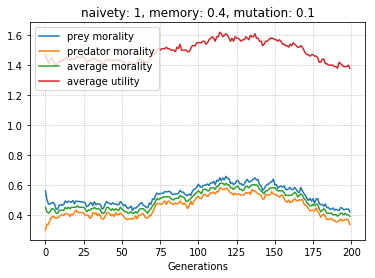

0.52 1.49
0.47 1.48
0.43 1.44
0.41 1.42
0.38 1.4
0.41 1.44
0.4 1.39
0.36 1.35
0.34 1.36
0.35 1.35
0.34 1.35
0.34 1.34
0.34 1.34
0.34 1.36
0.36 1.36
0.37 1.36
0.34 1.34
0.33 1.35
0.35 1.35
0.34 1.35
0.32 1.34
0.32 1.33
0.31 1.3
0.31 1.31
0.32 1.32
0.3 1.29
0.29 1.28
0.28 1.29
0.31 1.32
0.31 1.3
0.3 1.29
0.27 1.25
0.23 1.2
0.22 1.25
0.24 1.22
0.22 1.21
0.23 1.22
0.2 1.2
0.22 1.23
0.21 1.2
0.22 1.23
0.23 1.25
0.25 1.25
0.21 1.21
0.21 1.2
0.21 1.21
0.19 1.2
0.19 1.18
0.18 1.17
0.2 1.17
0.18 1.17
0.16 1.15
0.17 1.16
0.17 1.18
0.18 1.18
0.21 1.19
0.19 1.19
0.18 1.22
0.21 1.21
0.23 1.26
0.25 1.26
0.24 1.26
0.25 1.3
0.28 1.29
0.26 1.26
0.29 1.39
0.34 1.33
0.33 1.34
0.32 1.31
0.27 1.29
0.31 1.32
0.29 1.29
0.27 1.27
0.28 1.32
0.31 1.3
0.3 1.32
0.31 1.33
0.32 1.3
0.33 1.35
0.36 1.37
0.33 1.34
0.33 1.34
0.34 1.36
0.38 1.38
0.39 1.43
0.4 1.41
0.36 1.36
0.36 1.4
0.4 1.42
0.4 1.43
0.41 1.41
0.42 1.43
0.4 1.4
0.41 1.41
0.42 1.44
0.4 1.42
0.39 1.43
0.4 1.42
0.43 1.44
0.44 1.44
0.45 1.48
0.45 1.47
0.47 

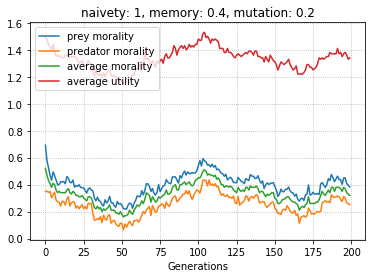

0.47 1.47
0.42 1.44
0.43 1.46
0.45 1.46
0.45 1.51
0.43 1.44
0.43 1.44
0.45 1.45
0.41 1.44
0.43 1.45
0.46 1.46
0.46 1.46
0.49 1.48
0.48 1.49
0.46 1.47
0.45 1.49
0.45 1.48
0.44 1.44
0.38 1.38
0.41 1.42
0.4 1.4
0.34 1.34
0.31 1.32
0.33 1.34
0.32 1.31
0.27 1.26
0.26 1.27
0.26 1.25
0.24 1.26
0.26 1.31
0.28 1.32
0.3 1.31
0.31 1.3
0.29 1.31
0.32 1.32
0.32 1.31
0.3 1.28
0.31 1.31
0.29 1.29
0.29 1.3
0.26 1.26
0.29 1.32
0.32 1.32
0.3 1.3
0.28 1.27
0.32 1.35
0.34 1.32
0.28 1.31
0.28 1.28
0.31 1.31
0.34 1.34
0.32 1.33
0.29 1.26
0.28 1.32
0.34 1.34
0.35 1.34
0.32 1.32
0.37 1.37
0.35 1.36
0.38 1.38
0.35 1.33
0.33 1.32
0.34 1.32
0.31 1.3
0.3 1.31
0.31 1.31
0.34 1.31
0.32 1.33
0.35 1.35
0.35 1.38
0.32 1.32
0.28 1.31
0.3 1.32
0.29 1.29
0.27 1.28
0.28 1.32
0.32 1.33
0.28 1.32
0.34 1.33
0.32 1.33
0.29 1.31
0.3 1.29
0.31 1.31
0.31 1.31
0.35 1.35
0.36 1.37
0.35 1.36
0.33 1.35
0.33 1.31
0.32 1.35
0.34 1.36
0.32 1.31
0.26 1.27
0.26 1.27
0.28 1.32
0.29 1.28
0.27 1.25
0.26 1.25
0.26 1.26
0.26 1.24
0.27 1.26
0.

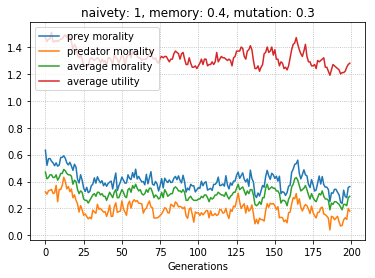

0.46 1.5
0.48 1.48
0.43 1.44
0.4 1.43
0.46 1.46
0.44 1.42
0.36 1.36
0.4 1.43
0.4 1.42
0.41 1.43
0.41 1.41
0.44 1.47
0.53 1.52
0.49 1.53
0.5 1.53
0.54 1.54
0.54 1.55
0.53 1.53
0.5 1.49
0.49 1.49
0.5 1.51
0.47 1.52
0.45 1.52
0.46 1.49
0.44 1.47
0.45 1.51
0.5 1.49
0.5 1.52
0.45 1.46
0.38 1.37
0.39 1.4
0.41 1.42
0.43 1.43
0.39 1.45
0.44 1.47
0.46 1.49
0.48 1.5
0.43 1.42
0.4 1.42
0.4 1.41
0.38 1.41
0.37 1.39
0.33 1.31
0.37 1.38
0.37 1.44
0.4 1.39
0.41 1.42
0.42 1.42
0.42 1.42
0.42 1.42
0.38 1.42
0.39 1.4
0.42 1.43
0.4 1.41
0.43 1.45
0.46 1.48
0.47 1.47
0.42 1.44
0.43 1.43
0.41 1.44
0.33 1.35
0.34 1.31
0.34 1.33
0.33 1.34
0.3 1.27
0.27 1.31
0.3 1.29
0.31 1.28
0.32 1.34
0.31 1.35
0.36 1.36
0.41 1.43
0.44 1.5
0.46 1.52
0.46 1.49
0.47 1.5
0.43 1.48
0.43 1.41
0.41 1.37
0.39 1.39
0.35 1.37
0.4 1.38
0.42 1.43
0.39 1.43
0.43 1.44
0.48 1.49
0.44 1.46
0.38 1.4
0.35 1.33
0.37 1.41
0.34 1.33
0.32 1.35
0.34 1.36
0.42 1.44
0.4 1.39
0.41 1.4
0.37 1.37
0.33 1.3
0.31 1.3
0.31 1.33
0.27 1.28
0.29 1.33
0.35 1

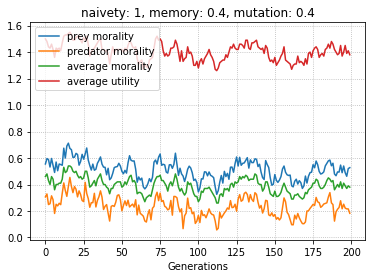

0.5 1.52
0.48 1.53
0.48 1.48
0.48 1.52
0.5 1.49
0.52 1.53
0.55 1.56
0.54 1.56
0.5 1.5
0.48 1.51
0.48 1.52
0.51 1.53
0.53 1.55
0.5 1.55
0.5 1.51
0.46 1.46
0.44 1.44
0.42 1.45
0.45 1.47
0.43 1.45
0.49 1.52
0.48 1.52
0.47 1.46
0.44 1.48
0.49 1.47
0.46 1.48
0.47 1.48
0.47 1.47
0.46 1.51
0.5 1.52
0.5 1.5
0.46 1.5
0.49 1.54
0.48 1.5
0.53 1.53
0.51 1.57
0.5 1.52
0.46 1.48
0.44 1.44
0.45 1.46
0.43 1.45
0.45 1.48
0.43 1.45
0.4 1.4
0.45 1.47
0.33 1.34
0.4 1.44
0.4 1.46
0.48 1.49
0.46 1.48
0.42 1.46
0.44 1.43
0.44 1.44
0.43 1.4
0.41 1.42
0.37 1.36
0.41 1.47
0.39 1.43
0.41 1.4
0.39 1.46
0.44 1.42
0.44 1.4
0.45 1.45
0.39 1.41
0.41 1.44
0.43 1.45
0.4 1.43
0.4 1.38
0.43 1.48
0.47 1.47
0.48 1.49
0.46 1.44
0.44 1.46
0.46 1.48
0.48 1.49
0.54 1.6
0.58 1.59
0.54 1.58
0.53 1.53
0.47 1.48
0.55 1.54
0.5 1.5
0.44 1.45
0.38 1.41
0.42 1.41
0.41 1.41
0.37 1.39
0.41 1.42
0.4 1.46
0.46 1.43
0.43 1.44
0.38 1.37
0.42 1.41
0.45 1.49
0.46 1.5
0.47 1.5
0.45 1.44
0.47 1.5
0.52 1.53
0.53 1.56
0.54 1.56
0.54 1.56
0.55 1.5

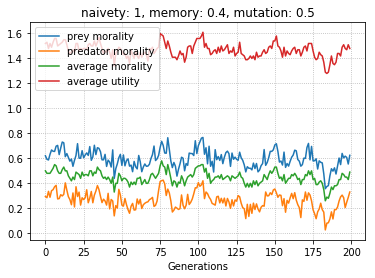

0.51 1.55
0.55 1.58
0.55 1.58
0.56 1.55
0.57 1.57
0.59 1.59
0.6 1.6
0.61 1.6
0.6 1.61
0.61 1.62
0.63 1.62
0.63 1.64
0.64 1.63
0.65 1.66
0.67 1.68
0.67 1.69
0.68 1.68
0.67 1.65
0.66 1.65
0.67 1.67
0.67 1.68
0.68 1.68
0.69 1.67
0.69 1.68
0.7 1.69
0.7 1.7
0.7 1.7
0.72 1.71
0.72 1.7
0.71 1.7
0.71 1.69
0.69 1.68
0.69 1.69
0.68 1.68
0.69 1.68
0.69 1.69
0.68 1.69
0.69 1.68
0.68 1.67
0.68 1.68
0.68 1.68
0.67 1.66
0.67 1.68
0.69 1.7
0.7 1.71
0.71 1.69
0.69 1.7
0.7 1.71
0.71 1.7
0.71 1.72
0.72 1.73
0.73 1.73
0.74 1.74
0.74 1.73
0.76 1.74
0.75 1.76
0.76 1.74
0.75 1.74
0.74 1.74
0.74 1.74
0.73 1.73
0.74 1.71
0.72 1.71
0.71 1.72
0.71 1.71
0.7 1.69
0.69 1.7
0.7 1.69
0.71 1.69
0.7 1.69
0.69 1.68
0.69 1.7
0.71 1.71
0.71 1.72
0.72 1.7
0.69 1.7
0.71 1.72
0.72 1.72
0.72 1.71
0.71 1.7
0.71 1.7
0.7 1.69
0.7 1.69
0.69 1.69
0.68 1.69
0.7 1.7
0.7 1.71
0.71 1.71
0.7 1.7
0.7 1.7
0.7 1.72
0.72 1.72
0.73 1.73
0.73 1.72
0.73 1.74
0.73 1.73
0.72 1.71
0.72 1.72
0.72 1.73
0.72 1.72
0.72 1.72
0.73 1.73
0.74 1.75
0.74 

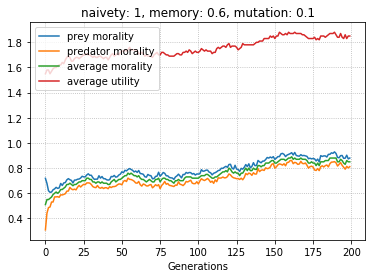

0.52 1.55
0.56 1.65
0.61 1.61
0.6 1.63
0.61 1.63
0.59 1.57
0.56 1.54
0.55 1.55
0.54 1.52
0.51 1.53
0.53 1.54
0.53 1.54
0.55 1.56
0.57 1.59
0.59 1.61
0.59 1.6
0.6 1.6
0.59 1.64
0.61 1.64
0.61 1.59
0.62 1.62
0.61 1.61
0.63 1.62
0.62 1.62
0.62 1.64
0.63 1.61
0.58 1.58
0.57 1.57
0.57 1.57
0.59 1.57
0.55 1.55
0.53 1.53
0.58 1.56
0.54 1.57
0.56 1.57
0.53 1.52
0.52 1.56
0.59 1.58
0.61 1.61
0.62 1.62
0.63 1.65
0.66 1.66
0.64 1.64
0.64 1.71
0.68 1.67
0.68 1.72
0.69 1.7
0.73 1.75
0.73 1.76
0.78 1.81
0.79 1.79
0.78 1.77
0.77 1.78
0.77 1.81
0.8 1.79
0.79 1.79
0.8 1.82
0.81 1.81
0.83 1.85
0.84 1.83
0.84 1.84
0.82 1.82
0.8 1.81
0.79 1.79
0.79 1.77
0.76 1.75
0.79 1.79
0.81 1.79
0.77 1.75
0.76 1.78
0.76 1.77
0.79 1.82
0.81 1.82
0.83 1.84
0.83 1.85
0.86 1.84
0.85 1.84
0.83 1.82
0.83 1.85
0.84 1.84
0.83 1.84
0.81 1.83
0.83 1.84
0.83 1.83
0.81 1.83
0.85 1.82
0.81 1.81
0.81 1.83
0.82 1.83
0.82 1.84
0.83 1.83
0.83 1.85
0.85 1.85
0.81 1.8
0.81 1.82
0.81 1.82
0.8 1.8
0.8 1.79
0.79 1.76
0.75 1.78
0.78 1.77
0.

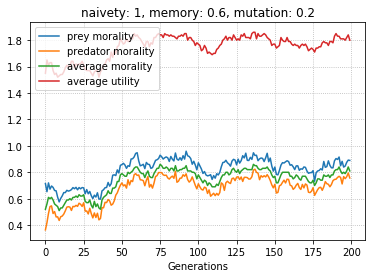

0.51 1.55
0.52 1.57
0.54 1.6
0.61 1.65
0.63 1.64
0.59 1.61
0.61 1.62
0.61 1.66
0.57 1.61
0.57 1.63
0.59 1.59
0.6 1.62
0.62 1.65
0.63 1.66
0.65 1.67
0.67 1.7
0.67 1.74
0.73 1.78
0.76 1.79
0.77 1.81
0.76 1.77
0.78 1.78
0.75 1.81
0.8 1.79
0.76 1.8
0.76 1.77
0.75 1.81
0.79 1.79
0.79 1.81
0.77 1.79
0.79 1.83
0.81 1.83
0.79 1.77
0.78 1.78
0.79 1.83
0.81 1.81
0.76 1.79
0.74 1.76
0.69 1.68
0.68 1.72
0.73 1.75
0.72 1.76
0.74 1.74
0.74 1.75
0.75 1.74
0.73 1.72
0.71 1.71
0.69 1.73
0.72 1.74
0.73 1.73
0.7 1.76
0.75 1.77
0.78 1.76
0.75 1.76
0.76 1.79
0.76 1.79
0.77 1.76
0.73 1.73
0.7 1.74
0.66 1.66
0.63 1.65
0.62 1.66
0.6 1.65
0.6 1.63
0.59 1.59
0.55 1.6
0.59 1.61
0.62 1.68
0.65 1.68
0.62 1.66
0.63 1.66
0.65 1.69
0.66 1.68
0.66 1.69
0.65 1.72
0.69 1.69
0.65 1.67
0.63 1.63
0.61 1.64
0.64 1.66
0.64 1.7
0.68 1.7
0.67 1.72
0.68 1.68
0.65 1.67
0.63 1.65
0.62 1.65
0.64 1.66
0.63 1.66
0.66 1.73
0.7 1.73
0.73 1.73
0.74 1.77
0.76 1.76
0.75 1.76
0.73 1.76
0.75 1.78
0.78 1.83
0.76 1.81
0.78 1.8
0.74 1.75
0.77

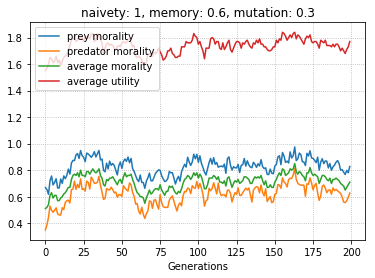

0.46 1.51
0.48 1.49
0.48 1.51
0.53 1.57
0.54 1.59
0.49 1.56
0.48 1.53
0.48 1.53
0.48 1.54
0.52 1.57
0.53 1.58
0.54 1.56
0.59 1.62
0.61 1.63
0.6 1.64
0.6 1.62
0.62 1.68
0.64 1.71
0.66 1.67
0.64 1.67
0.6 1.66
0.62 1.65
0.63 1.65
0.63 1.68
0.6 1.62
0.61 1.64
0.59 1.64
0.61 1.62
0.57 1.63
0.58 1.62
0.6 1.7
0.65 1.71
0.69 1.7
0.62 1.66
0.63 1.7
0.6 1.65
0.63 1.66
0.64 1.72
0.67 1.68
0.68 1.72
0.69 1.71
0.63 1.68
0.65 1.69
0.67 1.68
0.6 1.64
0.58 1.63
0.61 1.69
0.65 1.66
0.62 1.69
0.63 1.67
0.64 1.65
0.64 1.66
0.65 1.71
0.65 1.7
0.63 1.69
0.65 1.72
0.64 1.68
0.67 1.7
0.67 1.71
0.69 1.66
0.64 1.68
0.64 1.7
0.67 1.71
0.69 1.72
0.67 1.74
0.62 1.66
0.56 1.59
0.51 1.57
0.53 1.63
0.54 1.59
0.55 1.63
0.5 1.54
0.46 1.48
0.45 1.58
0.47 1.51
0.49 1.56
0.54 1.57
0.59 1.64
0.57 1.64
0.59 1.61
0.58 1.64
0.62 1.65
0.63 1.66
0.6 1.65
0.62 1.68
0.69 1.74
0.72 1.74
0.68 1.73
0.67 1.72
0.72 1.78
0.66 1.71
0.67 1.7
0.63 1.72
0.68 1.71
0.65 1.68
0.61 1.67
0.59 1.64
0.64 1.69
0.69 1.66
0.69 1.72
0.67 1.68
0.66 1

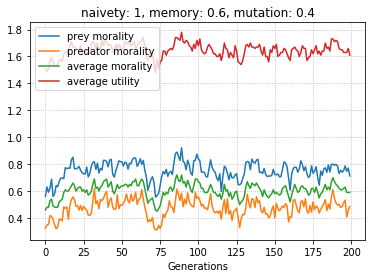

0.47 1.48
0.52 1.58
0.52 1.57
0.52 1.62
0.52 1.54
0.57 1.65
0.58 1.62
0.57 1.62
0.57 1.62
0.47 1.49
0.49 1.52
0.49 1.53
0.53 1.6
0.56 1.65
0.57 1.6
0.55 1.64
0.48 1.51
0.5 1.53
0.49 1.52
0.46 1.52
0.47 1.56
0.46 1.5
0.52 1.58
0.57 1.67
0.58 1.67
0.6 1.59
0.58 1.62
0.63 1.68
0.6 1.59
0.55 1.59
0.58 1.61
0.54 1.59
0.53 1.55
0.47 1.5
0.52 1.58
0.54 1.58
0.53 1.57
0.55 1.57
0.49 1.58
0.58 1.63
0.53 1.54
0.49 1.57
0.48 1.56
0.54 1.61
0.56 1.57
0.57 1.6
0.6 1.65
0.6 1.6
0.58 1.64
0.57 1.61
0.61 1.64
0.63 1.66
0.64 1.71
0.61 1.63
0.59 1.64
0.53 1.63
0.56 1.59
0.55 1.59
0.58 1.62
0.59 1.61
0.6 1.67
0.66 1.66
0.65 1.7
0.59 1.67
0.59 1.62
0.61 1.63
0.63 1.66
0.61 1.68
0.57 1.68
0.63 1.7
0.67 1.71
0.61 1.64
0.66 1.66
0.59 1.65
0.57 1.62
0.59 1.61
0.58 1.62
0.54 1.57
0.54 1.59
0.51 1.56
0.46 1.54
0.5 1.51
0.47 1.51
0.51 1.56
0.53 1.58
0.52 1.59
0.6 1.64
0.62 1.66
0.66 1.67
0.6 1.63
0.58 1.65
0.58 1.62
0.63 1.7
0.6 1.64
0.58 1.6
0.56 1.65
0.53 1.6
0.56 1.57
0.53 1.6
0.61 1.67
0.63 1.67
0.61 1.65
0.

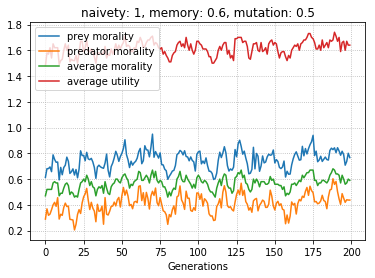

0.54 1.58
0.58 1.59
0.6 1.6
0.61 1.61
0.61 1.59
0.61 1.61
0.62 1.62
0.62 1.61
0.63 1.62
0.62 1.61
0.62 1.63
0.64 1.64
0.64 1.63
0.64 1.64
0.66 1.65
0.65 1.64
0.65 1.66
0.67 1.65
0.65 1.66
0.66 1.65
0.66 1.65
0.66 1.67
0.67 1.67
0.67 1.67
0.69 1.68
0.69 1.69
0.69 1.69
0.69 1.7
0.7 1.69
0.69 1.7
0.71 1.7
0.7 1.7
0.7 1.71
0.72 1.73
0.72 1.7
0.71 1.71
0.71 1.71
0.7 1.71
0.71 1.71
0.72 1.73
0.74 1.72
0.73 1.72
0.72 1.73
0.73 1.71
0.72 1.72
0.72 1.72
0.72 1.73
0.74 1.74
0.75 1.75
0.76 1.74
0.74 1.75
0.73 1.75
0.74 1.73
0.73 1.73
0.72 1.74
0.73 1.74
0.73 1.73
0.74 1.73
0.74 1.74
0.73 1.74
0.75 1.75
0.75 1.76
0.77 1.77
0.79 1.79
0.81 1.81
0.81 1.81
0.82 1.81
0.82 1.81
0.82 1.82
0.82 1.82
0.82 1.82
0.84 1.84
0.85 1.85
0.85 1.83
0.84 1.84
0.84 1.82
0.84 1.83
0.84 1.83
0.83 1.84
0.86 1.85
0.85 1.84
0.86 1.85
0.87 1.88
0.89 1.89
0.91 1.9
0.9 1.88
0.88 1.87
0.88 1.88
0.9 1.91
0.91 1.9
0.89 1.88
0.89 1.88
0.89 1.89
0.9 1.91
0.91 1.91
0.9 1.89
0.87 1.89
0.89 1.91
0.89 1.89
0.9 1.91
0.92 1.91
0.9 1.9


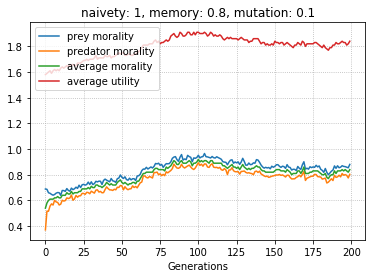

0.51 1.59
0.53 1.6
0.62 1.68
0.66 1.67
0.64 1.68
0.69 1.7
0.72 1.76
0.75 1.79
0.79 1.8
0.78 1.78
0.79 1.79
0.79 1.79
0.77 1.82
0.8 1.84
0.84 1.84
0.83 1.85
0.84 1.84
0.84 1.83
0.83 1.83
0.85 1.86
0.87 1.88
0.87 1.86
0.84 1.84
0.85 1.87
0.83 1.83
0.82 1.83
0.81 1.82
0.77 1.8
0.8 1.81
0.79 1.81
0.83 1.83
0.83 1.85
0.85 1.86
0.85 1.87
0.85 1.84
0.83 1.82
0.84 1.88
0.87 1.89
0.86 1.87
0.86 1.85
0.87 1.88
0.88 1.89
0.88 1.88
0.86 1.86
0.85 1.84
0.83 1.83
0.81 1.82
0.83 1.84
0.8 1.83
0.82 1.82
0.82 1.84
0.83 1.82
0.82 1.84
0.83 1.82
0.8 1.78
0.79 1.81
0.78 1.79
0.78 1.79
0.79 1.83
0.84 1.83
0.81 1.81
0.83 1.86
0.86 1.88
0.87 1.86
0.87 1.85
0.84 1.87
0.85 1.87
0.85 1.85
0.86 1.84
0.85 1.83
0.81 1.83
0.82 1.81
0.84 1.84
0.8 1.81
0.82 1.86
0.84 1.87
0.88 1.89
0.87 1.86
0.87 1.89
0.87 1.88
0.89 1.87
0.86 1.87
0.86 1.88
0.86 1.88
0.84 1.84
0.85 1.86
0.86 1.89
0.86 1.88
0.86 1.84
0.84 1.85
0.83 1.84
0.85 1.87
0.85 1.86
0.82 1.86
0.84 1.84
0.83 1.86
0.85 1.87
0.84 1.85
0.87 1.86
0.86 1.87
0.85 1.86

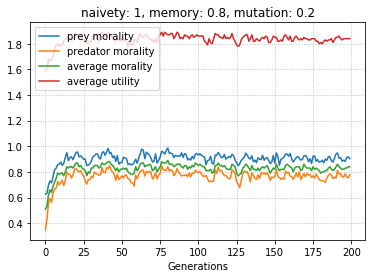

0.47 1.61
0.58 1.6
0.59 1.64
0.62 1.69
0.67 1.7
0.71 1.72
0.68 1.73
0.75 1.76
0.72 1.76
0.74 1.77
0.72 1.77
0.72 1.77
0.71 1.75
0.76 1.79
0.75 1.73
0.74 1.8
0.78 1.82
0.74 1.79
0.77 1.82
0.79 1.81
0.78 1.81
0.82 1.86
0.83 1.87
0.86 1.86
0.82 1.81
0.79 1.84
0.83 1.86
0.83 1.83
0.82 1.82
0.81 1.84
0.81 1.86
0.84 1.85
0.84 1.86
0.83 1.83
0.86 1.86
0.85 1.86
0.81 1.85
0.84 1.85
0.8 1.86
0.85 1.86
0.84 1.86
0.81 1.81
0.78 1.77
0.77 1.78
0.76 1.76
0.74 1.8
0.73 1.77
0.72 1.73
0.73 1.77
0.73 1.75
0.74 1.78
0.76 1.8
0.77 1.79
0.78 1.82
0.77 1.78
0.78 1.78
0.77 1.78
0.76 1.77
0.76 1.81
0.78 1.79
0.77 1.76
0.75 1.8
0.77 1.78
0.78 1.83
0.8 1.81
0.81 1.83
0.81 1.82
0.77 1.8
0.78 1.82
0.78 1.83
0.8 1.84
0.81 1.81
0.8 1.81
0.77 1.78
0.75 1.78
0.73 1.76
0.75 1.78
0.75 1.78
0.75 1.77
0.74 1.74
0.74 1.74
0.75 1.79
0.78 1.79
0.8 1.84
0.8 1.81
0.76 1.8
0.78 1.79
0.78 1.83
0.81 1.84
0.84 1.85
0.8 1.85
0.8 1.84
0.79 1.78
0.76 1.79
0.77 1.79
0.78 1.78
0.76 1.79
0.76 1.8
0.8 1.81
0.76 1.8
0.76 1.76
0.74 1.78

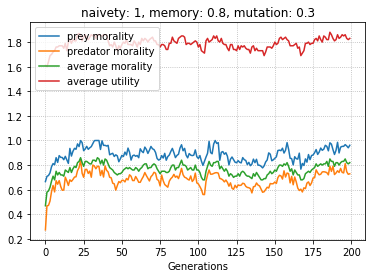

0.5 1.53
0.51 1.54
0.51 1.56
0.53 1.58
0.58 1.68
0.59 1.65
0.61 1.68
0.66 1.7
0.7 1.73
0.68 1.72
0.67 1.73
0.7 1.72
0.68 1.72
0.73 1.8
0.73 1.81
0.75 1.79
0.72 1.76
0.71 1.77
0.7 1.77
0.72 1.79
0.75 1.77
0.71 1.75
0.71 1.76
0.72 1.76
0.74 1.79
0.77 1.83
0.79 1.8
0.76 1.83
0.75 1.77
0.69 1.77
0.7 1.75
0.72 1.78
0.77 1.82
0.76 1.83
0.79 1.85
0.81 1.84
0.81 1.8
0.77 1.8
0.79 1.84
0.8 1.81
0.75 1.8
0.75 1.78
0.72 1.75
0.76 1.8
0.75 1.8
0.74 1.79
0.77 1.81
0.8 1.83
0.77 1.84
0.79 1.82
0.77 1.82
0.76 1.8
0.75 1.78
0.71 1.78
0.71 1.75
0.66 1.73
0.69 1.74
0.67 1.73
0.7 1.72
0.69 1.72
0.7 1.75
0.72 1.8
0.72 1.76
0.75 1.82
0.76 1.82
0.79 1.84
0.76 1.81
0.72 1.74
0.74 1.8
0.69 1.69
0.67 1.68
0.6 1.62
0.57 1.61
0.56 1.63
0.58 1.64
0.62 1.66
0.63 1.67
0.66 1.72
0.63 1.71
0.59 1.68
0.63 1.71
0.65 1.71
0.68 1.76
0.68 1.71
0.68 1.76
0.71 1.76
0.74 1.8
0.78 1.83
0.75 1.8
0.76 1.81
0.76 1.77
0.7 1.75
0.74 1.77
0.74 1.75
0.7 1.76
0.73 1.76
0.75 1.79
0.74 1.77
0.71 1.77
0.72 1.78
0.7 1.77
0.71 1.77
0.69 1

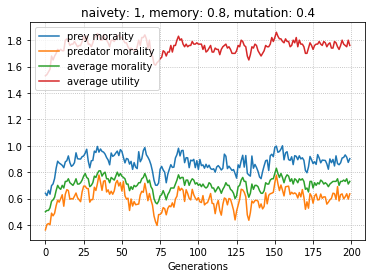

0.48 1.55
0.46 1.54
0.49 1.56
0.49 1.6
0.52 1.57
0.52 1.59
0.54 1.61
0.55 1.63
0.54 1.59
0.53 1.64
0.54 1.66
0.59 1.67
0.59 1.66
0.59 1.69
0.59 1.69
0.61 1.72
0.65 1.73
0.66 1.7
0.69 1.77
0.69 1.73
0.65 1.69
0.64 1.69
0.59 1.64
0.54 1.59
0.51 1.58
0.55 1.67
0.61 1.65
0.63 1.68
0.66 1.7
0.71 1.79
0.69 1.75
0.67 1.75
0.66 1.73
0.65 1.72
0.71 1.74
0.67 1.76
0.7 1.77
0.7 1.78
0.69 1.76
0.65 1.75
0.67 1.71
0.71 1.8
0.73 1.79
0.76 1.81
0.75 1.78
0.72 1.77
0.72 1.76
0.69 1.72
0.69 1.77
0.68 1.73
0.72 1.79
0.69 1.76
0.72 1.79
0.75 1.78
0.69 1.71
0.66 1.71
0.7 1.72
0.68 1.74
0.7 1.78
0.63 1.7
0.6 1.67
0.62 1.73
0.6 1.66
0.6 1.72
0.58 1.66
0.6 1.67
0.61 1.66
0.68 1.74
0.7 1.78
0.73 1.77
0.68 1.73
0.62 1.71
0.67 1.73
0.62 1.7
0.63 1.7
0.64 1.71
0.64 1.74
0.65 1.72
0.68 1.73
0.67 1.74
0.72 1.75
0.65 1.66
0.66 1.74
0.65 1.7
0.67 1.76
0.71 1.8
0.71 1.8
0.72 1.75
0.72 1.79
0.71 1.77
0.77 1.81
0.71 1.75
0.68 1.75
0.68 1.75
0.67 1.74
0.7 1.76
0.71 1.77
0.71 1.78
0.69 1.78
0.72 1.8
0.72 1.74
0.74 1.8
0.

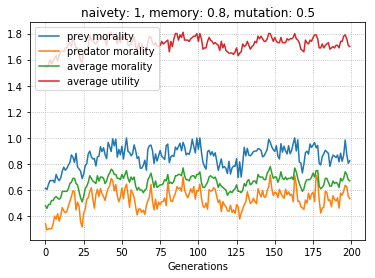

0.5 1.53
0.49 1.52
0.5 1.51
0.5 1.51
0.47 1.47
0.47 1.48
0.47 1.47
0.47 1.47
0.47 1.47
0.46 1.46
0.47 1.46
0.47 1.48
0.47 1.47
0.46 1.45
0.46 1.45
0.45 1.45
0.44 1.44
0.45 1.45
0.46 1.44
0.45 1.46
0.44 1.43
0.45 1.45
0.45 1.45
0.45 1.44
0.44 1.43
0.43 1.42
0.42 1.42
0.4 1.41
0.41 1.4
0.4 1.4
0.4 1.4
0.41 1.4
0.4 1.4
0.41 1.41
0.42 1.4
0.39 1.39
0.38 1.37
0.38 1.38
0.38 1.37
0.37 1.37
0.36 1.35
0.36 1.36
0.37 1.36
0.37 1.37
0.37 1.36
0.37 1.37
0.38 1.38
0.38 1.38
0.38 1.38
0.38 1.38
0.38 1.39
0.38 1.38
0.38 1.38
0.39 1.39
0.39 1.38
0.38 1.38
0.38 1.37
0.38 1.37
0.37 1.37
0.39 1.39
0.4 1.4
0.39 1.39
0.38 1.37
0.38 1.38
0.38 1.39
0.39 1.39
0.39 1.39
0.41 1.41
0.41 1.41
0.41 1.42
0.41 1.41
0.41 1.41
0.42 1.42
0.43 1.43
0.45 1.45
0.46 1.45
0.45 1.45
0.44 1.45
0.43 1.43
0.42 1.42
0.43 1.41
0.42 1.42
0.41 1.41
0.43 1.42
0.44 1.45
0.42 1.41
0.41 1.41
0.42 1.41
0.42 1.41
0.42 1.41
0.43 1.42
0.43 1.43
0.42 1.41
0.4 1.4
0.4 1.4
0.39 1.39
0.39 1.39
0.39 1.39
0.37 1.37
0.36 1.36
0.37 1.36
0.35 1.34

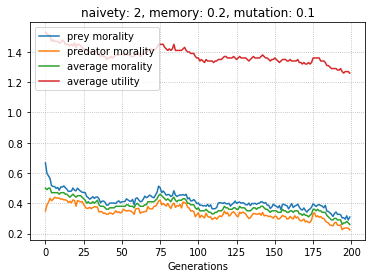

0.48 1.49
0.45 1.47
0.43 1.45
0.43 1.45
0.43 1.45
0.42 1.43
0.42 1.44
0.42 1.44
0.45 1.47
0.45 1.45
0.44 1.45
0.41 1.41
0.38 1.4
0.37 1.37
0.36 1.36
0.36 1.38
0.37 1.37
0.4 1.41
0.42 1.43
0.38 1.39
0.35 1.36
0.35 1.36
0.33 1.34
0.32 1.34
0.32 1.34
0.31 1.32
0.3 1.31
0.29 1.3
0.28 1.29
0.27 1.29
0.28 1.28
0.28 1.3
0.27 1.29
0.25 1.25
0.23 1.25
0.24 1.25
0.24 1.25
0.25 1.27
0.26 1.26
0.26 1.27
0.24 1.25
0.25 1.26
0.26 1.26
0.25 1.26
0.23 1.25
0.23 1.23
0.24 1.24
0.25 1.25
0.24 1.25
0.22 1.23
0.2 1.22
0.23 1.24
0.24 1.26
0.24 1.25
0.25 1.25
0.24 1.24
0.26 1.25
0.25 1.26
0.25 1.25
0.26 1.27
0.27 1.29
0.29 1.3
0.29 1.32
0.27 1.28
0.3 1.29
0.29 1.31
0.28 1.27
0.29 1.3
0.28 1.28
0.27 1.27
0.26 1.28
0.24 1.25
0.25 1.25
0.25 1.25
0.23 1.24
0.24 1.25
0.25 1.26
0.21 1.22
0.21 1.23
0.22 1.24
0.21 1.22
0.22 1.23
0.21 1.22
0.23 1.25
0.25 1.27
0.26 1.27
0.24 1.24
0.25 1.26
0.23 1.24
0.24 1.24
0.23 1.25
0.24 1.24
0.26 1.28
0.23 1.26
0.23 1.24
0.25 1.26
0.26 1.27
0.25 1.25
0.23 1.25
0.26 1.26
0.23 1.24

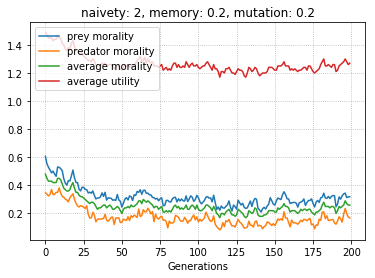

0.48 1.5
0.49 1.52
0.5 1.54
0.54 1.57
0.52 1.56
0.49 1.53
0.53 1.56
0.56 1.6
0.55 1.62
0.6 1.65
0.61 1.66
0.59 1.65
0.64 1.65
0.61 1.65
0.65 1.71
0.63 1.69
0.68 1.71
0.68 1.71
0.72 1.76
0.71 1.73
0.71 1.76
0.74 1.78
0.72 1.76
0.71 1.75
0.69 1.73
0.73 1.77
0.75 1.77
0.71 1.75
0.74 1.78
0.76 1.79
0.8 1.84
0.81 1.87
0.79 1.8
0.79 1.83
0.82 1.86
0.8 1.86
0.79 1.82
0.81 1.86
0.83 1.86
0.82 1.86
0.82 1.86
0.83 1.86
0.86 1.88
0.86 1.88
0.84 1.88
0.81 1.83
0.79 1.82
0.79 1.84
0.8 1.85
0.77 1.81
0.76 1.8
0.79 1.81
0.8 1.85
0.81 1.86
0.81 1.84
0.84 1.87
0.85 1.9
0.85 1.88
0.86 1.9
0.87 1.89
0.81 1.84
0.79 1.83
0.81 1.85
0.8 1.82
0.83 1.86
0.79 1.82
0.79 1.82
0.8 1.85
0.79 1.81
0.76 1.76
0.78 1.79
0.78 1.83
0.79 1.81
0.81 1.86
0.82 1.85
0.82 1.86
0.85 1.87
0.85 1.87
0.87 1.89
0.86 1.89
0.83 1.85
0.81 1.85
0.83 1.86
0.82 1.87
0.84 1.87
0.85 1.88
0.85 1.89
0.84 1.87
0.86 1.88
0.86 1.89
0.87 1.91
0.86 1.89
0.84 1.87
0.83 1.85
0.8 1.85
0.83 1.85
0.82 1.85
0.83 1.87
0.86 1.88
0.85 1.89
0.87 1.89
0.88 

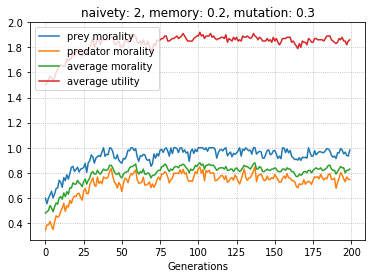

0.44 1.46
0.43 1.48
0.47 1.5
0.43 1.5
0.44 1.47
0.45 1.5
0.5 1.56
0.55 1.61
0.52 1.56
0.59 1.65
0.6 1.64
0.64 1.69
0.63 1.7
0.63 1.67
0.62 1.68
0.6 1.62
0.67 1.71
0.67 1.73
0.67 1.72
0.69 1.73
0.69 1.76
0.7 1.75
0.7 1.76
0.72 1.77
0.74 1.79
0.76 1.82
0.8 1.84
0.75 1.79
0.75 1.79
0.76 1.81
0.77 1.82
0.79 1.85
0.8 1.85
0.78 1.82
0.74 1.82
0.77 1.82
0.68 1.73
0.7 1.75
0.71 1.75
0.76 1.78
0.75 1.81
0.8 1.84
0.77 1.81
0.75 1.79
0.74 1.77
0.7 1.74
0.71 1.76
0.73 1.78
0.77 1.83
0.74 1.82
0.74 1.79
0.72 1.77
0.72 1.77
0.7 1.73
0.73 1.78
0.76 1.82
0.73 1.78
0.73 1.8
0.72 1.77
0.72 1.76
0.73 1.78
0.68 1.75
0.74 1.79
0.74 1.8
0.75 1.8
0.71 1.75
0.7 1.75
0.66 1.72
0.61 1.64
0.57 1.65
0.51 1.55
0.5 1.56
0.56 1.63
0.57 1.6
0.57 1.61
0.53 1.61
0.55 1.62
0.52 1.57
0.58 1.62
0.59 1.64
0.6 1.63
0.61 1.67
0.67 1.7
0.66 1.73
0.64 1.7
0.62 1.69
0.67 1.7
0.66 1.71
0.7 1.77
0.74 1.79
0.72 1.77
0.73 1.78
0.71 1.75
0.72 1.76
0.78 1.81
0.78 1.83
0.75 1.79
0.78 1.81
0.72 1.77
0.74 1.81
0.72 1.77
0.74 1.79
0.71 1

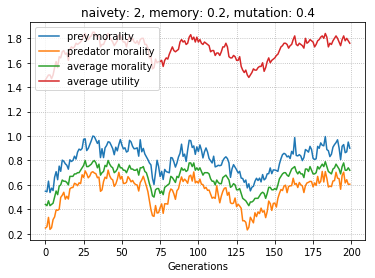

0.52 1.58
0.49 1.57
0.47 1.55
0.44 1.51
0.46 1.5
0.4 1.46
0.44 1.48
0.45 1.49
0.5 1.56
0.49 1.57
0.49 1.52
0.57 1.62
0.61 1.65
0.52 1.59
0.46 1.54
0.41 1.48
0.42 1.48
0.4 1.45
0.41 1.43
0.4 1.43
0.43 1.5
0.45 1.52
0.44 1.5
0.48 1.54
0.53 1.57
0.51 1.58
0.56 1.62
0.56 1.65
0.54 1.61
0.56 1.62
0.63 1.7
0.63 1.7
0.61 1.66
0.56 1.62
0.61 1.68
0.61 1.64
0.53 1.59
0.48 1.54
0.48 1.55
0.47 1.52
0.5 1.56
0.49 1.55
0.49 1.57
0.49 1.55
0.49 1.56
0.44 1.48
0.46 1.52
0.5 1.56
0.54 1.59
0.55 1.62
0.55 1.61
0.5 1.57
0.51 1.58
0.48 1.52
0.49 1.57
0.51 1.58
0.47 1.55
0.5 1.56
0.52 1.57
0.53 1.6
0.51 1.59
0.55 1.64
0.59 1.65
0.61 1.69
0.59 1.65
0.55 1.63
0.57 1.63
0.63 1.71
0.64 1.68
0.65 1.71
0.65 1.74
0.65 1.72
0.68 1.74
0.65 1.71
0.59 1.65
0.58 1.65
0.57 1.63
0.59 1.65
0.61 1.67
0.61 1.65
0.56 1.63
0.54 1.6
0.55 1.63
0.58 1.64
0.58 1.64
0.55 1.62
0.59 1.65
0.63 1.7
0.66 1.73
0.63 1.7
0.6 1.62
0.58 1.63
0.61 1.69
0.6 1.68
0.62 1.7
0.63 1.7
0.65 1.72
0.69 1.78
0.65 1.72
0.7 1.74
0.67 1.7
0.65 1.71
0.6

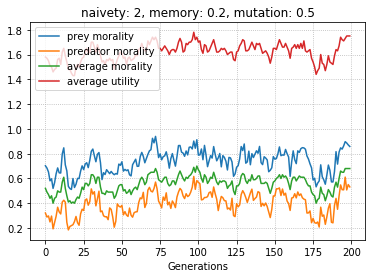

0.46 1.56
0.49 1.54
0.49 1.54
0.54 1.56
0.55 1.56
0.55 1.56
0.57 1.57
0.57 1.57
0.6 1.61
0.59 1.59
0.58 1.57
0.59 1.59
0.61 1.6
0.6 1.62
0.63 1.63
0.64 1.64
0.66 1.65
0.68 1.66
0.68 1.68
0.68 1.67
0.68 1.69
0.69 1.68
0.7 1.7
0.69 1.69
0.7 1.7
0.71 1.7
0.72 1.72
0.74 1.72
0.74 1.74
0.75 1.74
0.77 1.78
0.78 1.78
0.79 1.78
0.79 1.79
0.79 1.79
0.78 1.81
0.8 1.81
0.81 1.82
0.82 1.82
0.82 1.82
0.83 1.84
0.84 1.85
0.87 1.89
0.9 1.91
0.91 1.92
0.93 1.95
0.95 1.95
0.95 1.96
0.96 1.96
0.95 1.96
0.96 1.96
0.96 1.95
0.95 1.96
0.95 1.96
0.95 1.95
0.95 1.95
0.96 1.96
0.95 1.96
0.95 1.96
0.96 1.95
0.95 1.95
0.95 1.94
0.93 1.94
0.93 1.92
0.92 1.93
0.92 1.91
0.92 1.93
0.94 1.94
0.94 1.94
0.95 1.95
0.95 1.96
0.95 1.95
0.95 1.96
0.95 1.95
0.95 1.95
0.94 1.95
0.95 1.95
0.94 1.94
0.94 1.94
0.94 1.94
0.95 1.95
0.96 1.97
0.95 1.95
0.95 1.96
0.95 1.94
0.94 1.94
0.94 1.95
0.94 1.95
0.95 1.95
0.96 1.96
0.96 1.96
0.96 1.96
0.96 1.97
0.96 1.96
0.97 1.97
0.97 1.97
0.96 1.96
0.95 1.95
0.95 1.95
0.95 1.95
0.95 1.95


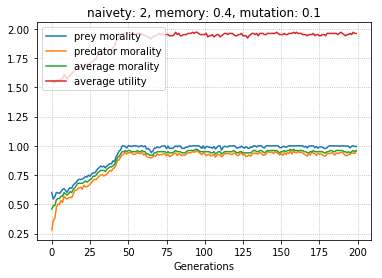

0.49 1.56
0.53 1.63
0.56 1.6
0.58 1.65
0.61 1.63
0.62 1.65
0.67 1.7
0.71 1.74
0.75 1.8
0.78 1.83
0.81 1.86
0.85 1.87
0.88 1.91
0.89 1.89
0.88 1.91
0.89 1.91
0.89 1.91
0.89 1.92
0.88 1.9
0.89 1.92
0.9 1.93
0.91 1.93
0.92 1.94
0.92 1.93
0.89 1.9
0.9 1.93
0.92 1.92
0.91 1.92
0.91 1.92
0.9 1.92
0.9 1.91
0.89 1.92
0.91 1.93
0.91 1.9
0.89 1.92
0.89 1.91
0.88 1.91
0.87 1.92
0.91 1.94
0.92 1.93
0.91 1.91
0.89 1.92
0.9 1.93
0.91 1.93
0.92 1.94
0.91 1.91
0.9 1.91
0.89 1.92
0.89 1.91
0.9 1.93
0.91 1.92
0.9 1.93
0.9 1.92
0.9 1.91
0.9 1.93
0.91 1.92
0.92 1.93
0.93 1.94
0.92 1.94
0.91 1.93
0.92 1.93
0.88 1.89
0.9 1.9
0.89 1.91
0.89 1.91
0.89 1.9
0.88 1.91
0.89 1.92
0.88 1.91
0.91 1.93
0.91 1.93
0.89 1.93
0.9 1.92
0.91 1.93
0.93 1.94
0.91 1.93
0.92 1.94
0.91 1.93
0.91 1.94
0.9 1.93
0.93 1.95
0.92 1.94
0.91 1.91
0.9 1.92
0.91 1.93
0.92 1.93
0.91 1.94
0.91 1.93
0.89 1.91
0.91 1.94
0.91 1.92
0.9 1.92
0.9 1.92
0.9 1.92
0.91 1.92
0.9 1.93
0.91 1.92
0.89 1.92
0.91 1.92
0.91 1.93
0.91 1.93
0.91 1.93
0.91 1.

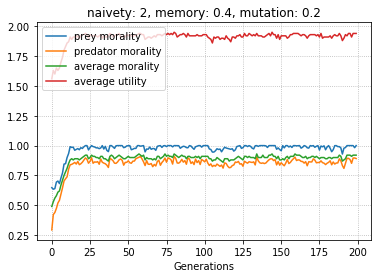

0.5 1.56
0.54 1.61
0.54 1.59
0.59 1.65
0.63 1.7
0.7 1.74
0.72 1.77
0.72 1.78
0.77 1.8
0.78 1.84
0.79 1.83
0.81 1.84
0.82 1.88
0.83 1.86
0.84 1.86
0.78 1.81
0.8 1.8
0.81 1.85
0.79 1.83
0.83 1.88
0.83 1.88
0.86 1.88
0.86 1.91
0.86 1.9
0.87 1.89
0.86 1.89
0.86 1.9
0.87 1.9
0.87 1.91
0.87 1.91
0.86 1.9
0.85 1.88
0.85 1.89
0.83 1.88
0.84 1.88
0.85 1.87
0.84 1.88
0.83 1.88
0.82 1.87
0.82 1.88
0.84 1.89
0.86 1.89
0.85 1.89
0.87 1.9
0.83 1.87
0.85 1.89
0.84 1.87
0.84 1.88
0.87 1.91
0.86 1.91
0.87 1.89
0.86 1.9
0.87 1.91
0.87 1.89
0.86 1.88
0.89 1.92
0.88 1.9
0.88 1.91
0.85 1.89
0.85 1.88
0.87 1.88
0.85 1.87
0.84 1.88
0.81 1.83
0.81 1.83
0.83 1.85
0.81 1.87
0.87 1.91
0.88 1.91
0.86 1.89
0.87 1.9
0.87 1.9
0.86 1.9
0.86 1.88
0.85 1.85
0.83 1.87
0.84 1.89
0.84 1.89
0.84 1.89
0.85 1.87
0.84 1.88
0.85 1.9
0.88 1.89
0.88 1.91
0.87 1.89
0.86 1.91
0.82 1.87
0.81 1.86
0.8 1.84
0.82 1.85
0.79 1.84
0.83 1.87
0.83 1.85
0.8 1.85
0.83 1.88
0.81 1.85
0.84 1.89
0.86 1.9
0.86 1.88
0.85 1.88
0.85 1.9
0.84 1.87
0

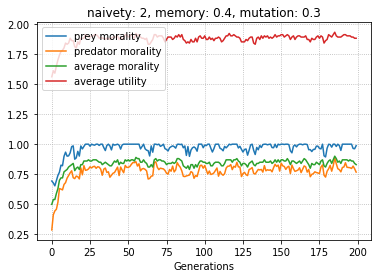

0.53 1.6
0.58 1.66
0.64 1.71
0.64 1.74
0.64 1.7
0.71 1.81
0.75 1.82
0.74 1.8
0.75 1.82
0.7 1.77
0.71 1.78
0.72 1.78
0.7 1.77
0.72 1.8
0.77 1.83
0.78 1.84
0.79 1.85
0.75 1.83
0.78 1.83
0.78 1.83
0.77 1.83
0.78 1.84
0.81 1.84
0.79 1.84
0.78 1.84
0.8 1.83
0.79 1.82
0.79 1.84
0.74 1.8
0.71 1.76
0.7 1.78
0.73 1.79
0.7 1.75
0.67 1.72
0.69 1.76
0.61 1.68
0.66 1.71
0.65 1.72
0.65 1.71
0.69 1.75
0.71 1.79
0.69 1.73
0.69 1.75
0.74 1.81
0.74 1.78
0.75 1.82
0.82 1.87
0.79 1.85
0.79 1.84
0.8 1.85
0.79 1.86
0.8 1.85
0.81 1.85
0.79 1.82
0.78 1.84
0.76 1.81
0.77 1.82
0.72 1.79
0.73 1.78
0.72 1.78
0.75 1.8
0.74 1.8
0.74 1.75
0.68 1.77
0.7 1.76
0.72 1.8
0.76 1.83
0.78 1.84
0.74 1.79
0.73 1.79
0.75 1.83
0.77 1.82
0.78 1.82
0.8 1.86
0.78 1.85
0.77 1.84
0.76 1.79
0.71 1.78
0.73 1.78
0.72 1.81
0.71 1.79
0.72 1.77
0.74 1.82
0.8 1.86
0.81 1.87
0.82 1.84
0.8 1.85
0.8 1.86
0.85 1.89
0.8 1.86
0.81 1.87
0.81 1.86
0.83 1.88
0.78 1.83
0.79 1.83
0.79 1.86
0.8 1.84
0.78 1.84
0.79 1.84
0.76 1.84
0.75 1.83
0.75 1.82
0.

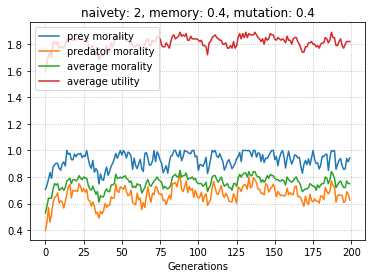

0.52 1.55
0.56 1.66
0.56 1.66
0.63 1.74
0.65 1.75
0.65 1.73
0.69 1.78
0.7 1.78
0.76 1.83
0.74 1.81
0.7 1.78
0.69 1.75
0.68 1.77
0.68 1.75
0.65 1.74
0.68 1.75
0.68 1.75
0.71 1.79
0.72 1.77
0.74 1.81
0.79 1.85
0.75 1.82
0.74 1.8
0.76 1.82
0.72 1.81
0.72 1.79
0.75 1.8
0.77 1.84
0.79 1.86
0.77 1.84
0.74 1.78
0.74 1.81
0.76 1.79
0.74 1.79
0.74 1.8
0.78 1.86
0.75 1.82
0.74 1.81
0.77 1.82
0.73 1.8
0.71 1.78
0.71 1.78
0.71 1.78
0.68 1.77
0.71 1.78
0.76 1.82
0.75 1.81
0.69 1.8
0.77 1.84
0.77 1.84
0.78 1.83
0.74 1.81
0.76 1.8
0.73 1.81
0.74 1.82
0.71 1.79
0.75 1.81
0.74 1.8
0.75 1.81
0.73 1.82
0.72 1.8
0.7 1.77
0.72 1.79
0.71 1.77
0.73 1.81
0.75 1.81
0.76 1.84
0.75 1.8
0.74 1.81
0.68 1.77
0.71 1.78
0.75 1.82
0.74 1.79
0.74 1.81
0.74 1.82
0.75 1.82
0.72 1.77
0.7 1.78
0.64 1.74
0.63 1.73
0.67 1.76
0.69 1.73
0.67 1.76
0.75 1.82
0.76 1.84
0.78 1.83
0.78 1.81
0.76 1.8
0.73 1.79
0.72 1.79
0.79 1.82
0.75 1.78
0.74 1.81
0.69 1.77
0.69 1.78
0.72 1.79
0.7 1.76
0.71 1.77
0.73 1.79
0.74 1.81
0.66 1.76
0.64 

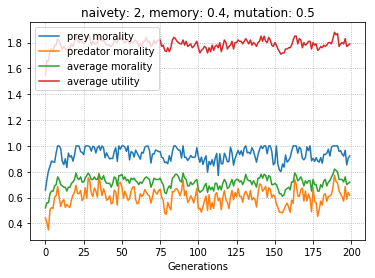

0.48 1.58
0.54 1.64
0.58 1.67
0.65 1.7
0.71 1.74
0.75 1.76
0.76 1.77
0.77 1.79
0.79 1.82
0.84 1.84
0.87 1.88
0.9 1.9
0.91 1.93
0.93 1.94
0.94 1.94
0.94 1.95
0.95 1.96
0.95 1.96
0.96 1.96
0.96 1.96
0.96 1.96
0.95 1.96
0.95 1.95
0.95 1.95
0.96 1.95
0.95 1.95
0.95 1.96
0.96 1.96
0.96 1.96
0.96 1.96
0.96 1.96
0.97 1.97
0.97 1.97
0.97 1.97
0.97 1.97
0.96 1.95
0.95 1.95
0.95 1.95
0.95 1.95
0.96 1.96
0.96 1.96
0.96 1.95
0.96 1.96
0.96 1.96
0.95 1.93
0.95 1.96
0.96 1.97
0.95 1.95
0.95 1.95
0.95 1.95
0.95 1.95
0.95 1.95
0.95 1.96
0.95 1.96
0.96 1.96
0.96 1.97
0.96 1.97
0.97 1.95
0.96 1.95
0.95 1.95
0.95 1.96
0.96 1.95
0.96 1.96
0.95 1.96
0.95 1.95
0.96 1.96
0.95 1.96
0.96 1.96
0.96 1.96
0.96 1.96
0.96 1.96
0.97 1.97
0.97 1.97
0.96 1.97
0.95 1.96
0.95 1.95
0.94 1.95
0.95 1.96
0.95 1.96
0.95 1.96
0.96 1.96
0.95 1.96
0.96 1.97
0.96 1.96
0.96 1.96
0.96 1.96
0.96 1.97
0.96 1.96
0.96 1.97
0.96 1.97
0.96 1.95
0.95 1.95
0.95 1.95
0.95 1.96
0.96 1.97
0.96 1.97
0.96 1.96
0.96 1.96
0.96 1.96
0.95 1.95
0.9

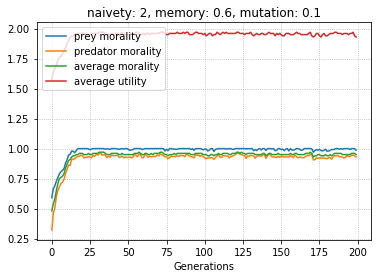

0.52 1.64
0.57 1.63
0.66 1.72
0.7 1.73
0.75 1.79
0.81 1.86
0.84 1.85
0.82 1.86
0.83 1.87
0.86 1.87
0.86 1.88
0.87 1.9
0.89 1.92
0.89 1.92
0.91 1.91
0.9 1.94
0.9 1.91
0.89 1.92
0.91 1.91
0.9 1.92
0.9 1.93
0.89 1.92
0.91 1.94
0.9 1.91
0.9 1.92
0.91 1.91
0.91 1.93
0.89 1.92
0.89 1.92
0.9 1.92
0.91 1.91
0.89 1.92
0.9 1.92
0.91 1.94
0.91 1.94
0.9 1.91
0.91 1.92
0.91 1.92
0.91 1.93
0.92 1.94
0.91 1.94
0.93 1.94
0.94 1.95
0.92 1.94
0.91 1.93
0.93 1.95
0.93 1.95
0.91 1.93
0.91 1.93
0.9 1.93
0.91 1.93
0.92 1.94
0.91 1.92
0.92 1.93
0.9 1.92
0.9 1.92
0.9 1.91
0.89 1.93
0.91 1.93
0.92 1.93
0.9 1.92
0.91 1.93
0.91 1.93
0.92 1.94
0.93 1.94
0.92 1.95
0.91 1.94
0.9 1.93
0.91 1.93
0.91 1.94
0.92 1.94
0.91 1.92
0.91 1.92
0.9 1.92
0.91 1.93
0.91 1.93
0.88 1.91
0.9 1.93
0.91 1.94
0.92 1.94
0.92 1.93
0.91 1.92
0.91 1.93
0.9 1.93
0.93 1.95
0.92 1.93
0.93 1.94
0.92 1.93
0.93 1.94
0.93 1.94
0.91 1.93
0.91 1.93
0.91 1.94
0.91 1.91
0.9 1.91
0.9 1.92
0.92 1.93
0.92 1.95
0.9 1.93
0.92 1.92
0.91 1.92
0.91 1.93
0.9

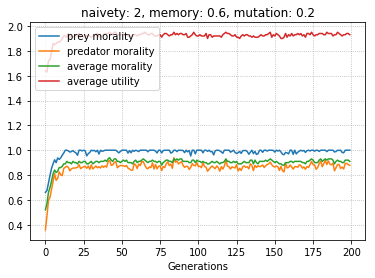

0.47 1.6
0.52 1.62
0.57 1.66
0.6 1.69
0.66 1.73
0.74 1.8
0.79 1.86
0.83 1.89
0.87 1.9
0.85 1.86
0.82 1.84
0.82 1.88
0.86 1.91
0.84 1.89
0.85 1.9
0.89 1.89
0.88 1.91
0.87 1.91
0.87 1.92
0.87 1.91
0.88 1.9
0.87 1.91
0.86 1.91
0.84 1.88
0.87 1.9
0.88 1.92
0.85 1.89
0.85 1.89
0.87 1.89
0.85 1.87
0.83 1.88
0.85 1.88
0.87 1.91
0.88 1.91
0.85 1.89
0.86 1.9
0.86 1.88
0.86 1.89
0.84 1.88
0.84 1.88
0.84 1.88
0.84 1.88
0.87 1.9
0.88 1.91
0.85 1.89
0.86 1.89
0.88 1.93
0.86 1.91
0.86 1.89
0.84 1.86
0.82 1.86
0.82 1.87
0.85 1.89
0.86 1.91
0.84 1.87
0.85 1.89
0.88 1.9
0.88 1.9
0.87 1.89
0.87 1.91
0.88 1.92
0.89 1.93
0.86 1.9
0.86 1.9
0.86 1.89
0.85 1.9
0.87 1.91
0.87 1.91
0.88 1.92
0.86 1.91
0.87 1.9
0.87 1.9
0.88 1.91
0.89 1.93
0.87 1.9
0.84 1.87
0.86 1.89
0.85 1.9
0.86 1.91
0.87 1.9
0.85 1.88
0.85 1.87
0.81 1.84
0.83 1.88
0.81 1.87
0.85 1.9
0.84 1.9
0.83 1.86
0.79 1.84
0.83 1.88
0.85 1.89
0.87 1.91
0.87 1.9
0.88 1.92
0.87 1.91
0.87 1.91
0.89 1.93
0.86 1.9
0.87 1.88
0.85 1.89
0.84 1.89
0.84 1.88
0.8

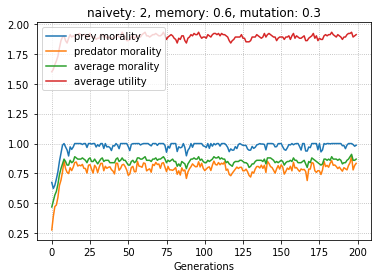

0.45 1.58
0.5 1.6
0.56 1.67
0.67 1.76
0.73 1.8
0.78 1.85
0.77 1.84
0.77 1.83
0.76 1.84
0.77 1.84
0.78 1.84
0.81 1.85
0.79 1.87
0.83 1.89
0.82 1.87
0.82 1.89
0.83 1.89
0.83 1.89
0.8 1.86
0.81 1.85
0.8 1.87
0.81 1.88
0.76 1.83
0.76 1.83
0.8 1.85
0.78 1.82
0.79 1.85
0.77 1.85
0.79 1.82
0.79 1.85
0.82 1.88
0.82 1.87
0.8 1.87
0.81 1.85
0.8 1.85
0.85 1.89
0.83 1.89
0.83 1.88
0.82 1.87
0.82 1.88
0.81 1.85
0.78 1.85
0.74 1.8
0.75 1.84
0.75 1.81
0.76 1.82
0.8 1.87
0.8 1.85
0.8 1.84
0.76 1.81
0.78 1.83
0.73 1.79
0.75 1.83
0.77 1.82
0.76 1.82
0.72 1.82
0.76 1.84
0.76 1.84
0.78 1.85
0.78 1.84
0.76 1.85
0.78 1.86
0.79 1.85
0.8 1.86
0.82 1.88
0.79 1.87
0.82 1.86
0.85 1.89
0.86 1.91
0.85 1.9
0.84 1.88
0.81 1.88
0.8 1.87
0.8 1.87
0.79 1.84
0.77 1.85
0.8 1.87
0.85 1.91
0.86 1.91
0.86 1.9
0.81 1.88
0.8 1.86
0.82 1.86
0.78 1.84
0.8 1.87
0.78 1.84
0.81 1.88
0.82 1.86
0.8 1.88
0.83 1.89
0.82 1.88
0.79 1.87
0.8 1.87
0.8 1.87
0.76 1.83
0.8 1.84
0.82 1.87
0.81 1.85
0.78 1.86
0.81 1.88
0.83 1.87
0.84 1.86
0.79

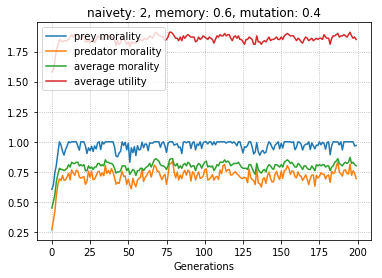

0.48 1.6
0.56 1.66
0.59 1.65
0.59 1.71
0.62 1.73
0.61 1.73
0.63 1.73
0.65 1.78
0.67 1.78
0.72 1.79
0.72 1.81
0.74 1.81
0.76 1.85
0.72 1.82
0.67 1.75
0.7 1.79
0.66 1.76
0.65 1.76
0.67 1.76
0.68 1.75
0.69 1.76
0.67 1.79
0.71 1.82
0.75 1.83
0.75 1.81
0.72 1.77
0.7 1.8
0.68 1.78
0.7 1.77
0.66 1.76
0.66 1.79
0.69 1.79
0.71 1.8
0.74 1.83
0.78 1.86
0.8 1.87
0.78 1.85
0.73 1.82
0.68 1.77
0.73 1.8
0.71 1.79
0.67 1.76
0.68 1.78
0.68 1.79
0.7 1.77
0.73 1.8
0.77 1.85
0.77 1.83
0.78 1.84
0.76 1.83
0.74 1.81
0.7 1.81
0.72 1.77
0.7 1.8
0.68 1.72
0.71 1.82
0.75 1.82
0.74 1.82
0.73 1.81
0.76 1.85
0.76 1.85
0.74 1.83
0.78 1.87
0.75 1.83
0.74 1.82
0.75 1.82
0.8 1.87
0.75 1.84
0.7 1.79
0.71 1.8
0.72 1.82
0.75 1.81
0.77 1.83
0.75 1.84
0.77 1.83
0.79 1.86
0.77 1.85
0.78 1.85
0.8 1.87
0.77 1.85
0.81 1.88
0.8 1.84
0.77 1.85
0.74 1.81
0.71 1.8
0.7 1.8
0.73 1.82
0.72 1.8
0.72 1.79
0.72 1.81
0.74 1.81
0.75 1.81
0.75 1.84
0.76 1.83
0.78 1.85
0.79 1.86
0.76 1.8
0.76 1.85
0.73 1.81
0.74 1.83
0.75 1.83
0.74 1.85
0.7

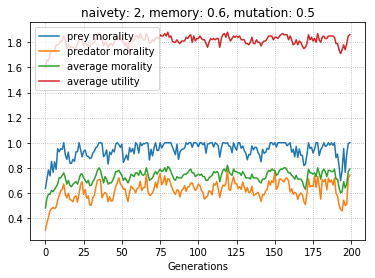

0.46 1.6
0.47 1.6
0.56 1.66
0.63 1.69
0.69 1.74
0.72 1.76
0.77 1.84
0.84 1.88
0.9 1.92
0.92 1.94
0.94 1.96
0.95 1.96
0.95 1.96
0.95 1.96
0.95 1.95
0.94 1.96
0.96 1.96
0.96 1.97
0.95 1.95
0.96 1.95
0.96 1.96
0.95 1.96
0.95 1.96
0.96 1.97
0.96 1.97
0.95 1.95
0.96 1.95
0.94 1.95
0.95 1.95
0.95 1.95
0.95 1.96
0.96 1.97
0.97 1.97
0.96 1.96
0.96 1.95
0.95 1.96
0.96 1.97
0.96 1.96
0.96 1.97
0.96 1.97
0.95 1.96
0.96 1.96
0.96 1.96
0.96 1.96
0.96 1.96
0.96 1.97
0.96 1.97
0.96 1.97
0.96 1.96
0.96 1.95
0.95 1.95
0.95 1.95
0.95 1.95
0.95 1.96
0.95 1.95
0.94 1.95
0.95 1.96
0.96 1.96
0.95 1.95
0.94 1.94
0.94 1.95
0.95 1.96
0.95 1.95
0.95 1.96
0.95 1.96
0.95 1.96
0.96 1.96
0.96 1.96
0.96 1.97
0.96 1.96
0.96 1.95
0.96 1.97
0.96 1.96
0.95 1.96
0.96 1.95
0.94 1.94
0.94 1.95
0.93 1.95
0.94 1.94
0.94 1.96
0.96 1.95
0.96 1.96
0.95 1.96
0.94 1.96
0.95 1.95
0.95 1.95
0.95 1.96
0.95 1.95
0.96 1.97
0.96 1.96
0.96 1.96
0.96 1.95
0.94 1.94
0.95 1.95
0.95 1.95
0.95 1.96
0.97 1.96
0.96 1.97
0.96 1.97
0.97 1.97
0.9

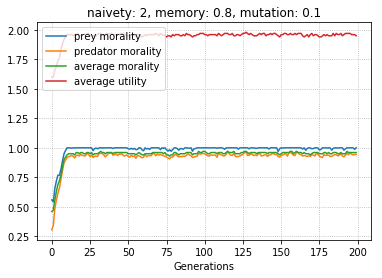

0.44 1.6
0.54 1.65
0.57 1.69
0.64 1.75
0.73 1.83
0.81 1.88
0.86 1.9
0.87 1.89
0.89 1.91
0.92 1.94
0.92 1.93
0.91 1.92
0.9 1.92
0.91 1.93
0.93 1.95
0.93 1.93
0.92 1.93
0.92 1.94
0.91 1.93
0.9 1.93
0.91 1.94
0.92 1.94
0.92 1.95
0.92 1.94
0.93 1.94
0.9 1.93
0.9 1.93
0.89 1.91
0.89 1.92
0.9 1.93
0.93 1.94
0.9 1.93
0.91 1.91
0.91 1.94
0.9 1.93
0.92 1.94
0.94 1.95
0.94 1.96
0.91 1.94
0.92 1.94
0.91 1.94
0.92 1.95
0.92 1.94
0.92 1.94
0.92 1.93
0.9 1.92
0.9 1.93
0.9 1.94
0.9 1.92
0.89 1.91
0.89 1.9
0.88 1.91
0.89 1.93
0.89 1.91
0.89 1.93
0.89 1.92
0.9 1.92
0.91 1.94
0.91 1.93
0.9 1.92
0.91 1.93
0.9 1.93
0.9 1.93
0.9 1.92
0.9 1.93
0.91 1.93
0.9 1.91
0.9 1.93
0.9 1.93
0.9 1.92
0.91 1.93
0.91 1.92
0.91 1.93
0.92 1.93
0.92 1.92
0.9 1.93
0.89 1.91
0.92 1.94
0.92 1.94
0.9 1.93
0.92 1.94
0.9 1.94
0.91 1.94
0.92 1.95
0.92 1.93
0.91 1.93
0.91 1.94
0.93 1.94
0.93 1.95
0.93 1.94
0.92 1.91
0.88 1.91
0.9 1.93
0.89 1.92
0.89 1.89
0.9 1.9
0.89 1.93
0.89 1.91
0.87 1.9
0.9 1.9
0.89 1.92
0.92 1.95
0.91 1.94
0.9

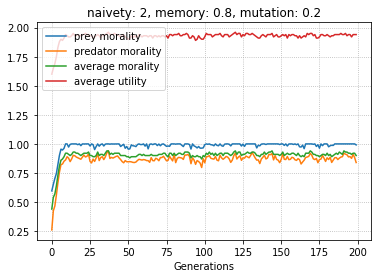

0.53 1.69
0.64 1.75
0.71 1.8
0.81 1.86
0.8 1.87
0.8 1.88
0.79 1.86
0.84 1.89
0.84 1.89
0.83 1.86
0.84 1.89
0.88 1.91
0.88 1.91
0.84 1.9
0.83 1.89
0.86 1.91
0.86 1.91
0.86 1.9
0.84 1.9
0.86 1.9
0.86 1.91
0.85 1.89
0.85 1.89
0.85 1.91
0.86 1.91
0.85 1.9
0.84 1.89
0.86 1.91
0.89 1.92
0.88 1.92
0.89 1.92
0.88 1.93
0.89 1.93
0.86 1.9
0.82 1.88
0.83 1.87
0.83 1.89
0.83 1.88
0.85 1.88
0.88 1.92
0.85 1.9
0.87 1.9
0.86 1.9
0.87 1.91
0.87 1.92
0.89 1.92
0.88 1.91
0.87 1.91
0.85 1.9
0.83 1.87
0.85 1.9
0.87 1.91
0.9 1.93
0.88 1.91
0.87 1.89
0.85 1.89
0.86 1.9
0.87 1.91
0.9 1.93
0.87 1.91
0.89 1.92
0.85 1.89
0.87 1.91
0.84 1.89
0.84 1.89
0.86 1.88
0.85 1.91
0.84 1.89
0.85 1.9
0.85 1.9
0.87 1.91
0.86 1.9
0.87 1.91
0.86 1.89
0.86 1.91
0.87 1.9
0.86 1.91
0.86 1.89
0.84 1.91
0.88 1.92
0.88 1.92
0.85 1.89
0.87 1.9
0.87 1.91
0.85 1.9
0.87 1.91
0.85 1.89
0.85 1.9
0.88 1.92
0.9 1.94
0.9 1.93
0.89 1.92
0.88 1.92
0.88 1.9
0.85 1.9
0.82 1.88
0.84 1.89
0.87 1.91
0.88 1.91
0.85 1.9
0.86 1.91
0.87 1.91
0.88 1.92

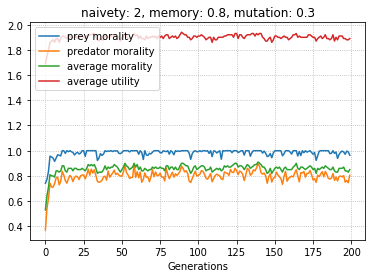

0.56 1.7
0.61 1.76
0.7 1.79
0.73 1.84
0.75 1.81
0.79 1.87
0.81 1.88
0.82 1.89
0.84 1.9
0.86 1.87
0.81 1.87
0.79 1.87
0.81 1.83
0.81 1.88
0.83 1.88
0.82 1.89
0.81 1.88
0.79 1.87
0.8 1.87
0.78 1.87
0.8 1.87
0.81 1.86
0.79 1.88
0.81 1.87
0.84 1.89
0.84 1.9
0.83 1.88
0.83 1.9
0.84 1.88
0.79 1.86
0.81 1.88
0.83 1.89
0.82 1.89
0.87 1.91
0.86 1.9
0.84 1.9
0.83 1.86
0.79 1.86
0.79 1.87
0.81 1.86
0.8 1.86
0.79 1.86
0.81 1.88
0.87 1.91
0.87 1.92
0.83 1.88
0.8 1.87
0.78 1.85
0.81 1.88
0.84 1.9
0.82 1.88
0.81 1.89
0.86 1.9
0.83 1.9
0.82 1.86
0.79 1.86
0.8 1.84
0.79 1.87
0.79 1.88
0.8 1.86
0.79 1.83
0.78 1.85
0.76 1.84
0.8 1.85
0.79 1.85
0.81 1.87
0.86 1.9
0.84 1.89
0.82 1.89
0.81 1.88
0.8 1.87
0.79 1.86
0.77 1.85
0.8 1.87
0.82 1.88
0.83 1.89
0.8 1.88
0.8 1.86
0.81 1.86
0.78 1.86
0.75 1.81
0.79 1.87
0.79 1.86
0.82 1.89
0.76 1.84
0.81 1.88
0.81 1.87
0.82 1.89
0.78 1.85
0.81 1.87
0.82 1.88
0.78 1.86
0.82 1.88
0.86 1.91
0.84 1.88
0.81 1.86
0.8 1.87
0.8 1.85
0.79 1.85
0.76 1.84
0.76 1.85
0.75 1.83
0.76

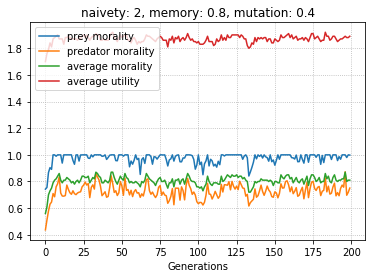

0.51 1.6
0.45 1.64
0.53 1.68
0.62 1.76
0.7 1.83
0.71 1.82
0.73 1.82
0.74 1.82
0.76 1.84
0.75 1.84
0.77 1.86
0.81 1.87
0.78 1.85
0.8 1.87
0.75 1.85
0.81 1.88
0.77 1.86
0.75 1.83
0.73 1.82
0.76 1.84
0.76 1.86
0.77 1.84
0.77 1.84
0.73 1.82
0.76 1.85
0.72 1.83
0.75 1.82
0.71 1.79
0.73 1.84
0.76 1.85
0.8 1.85
0.78 1.86
0.82 1.88
0.83 1.89
0.87 1.92
0.84 1.89
0.82 1.89
0.77 1.85
0.75 1.83
0.73 1.84
0.77 1.86
0.77 1.85
0.8 1.86
0.76 1.86
0.79 1.86
0.83 1.89
0.82 1.88
0.8 1.85
0.81 1.88
0.8 1.88
0.77 1.84
0.77 1.86
0.83 1.88
0.8 1.86
0.79 1.88
0.8 1.88
0.8 1.88
0.74 1.84
0.75 1.83
0.78 1.85
0.75 1.83
0.81 1.87
0.76 1.85
0.74 1.84
0.76 1.84
0.8 1.87
0.75 1.83
0.74 1.81
0.77 1.83
0.75 1.83
0.75 1.84
0.78 1.84
0.76 1.85
0.78 1.85
0.77 1.85
0.79 1.84
0.75 1.81
0.76 1.81
0.78 1.87
0.76 1.83
0.76 1.85
0.73 1.82
0.76 1.85
0.74 1.84
0.79 1.84
0.8 1.88
0.78 1.86
0.73 1.82
0.71 1.81
0.7 1.81
0.7 1.8
0.74 1.79
0.72 1.82
0.72 1.8
0.72 1.83
0.73 1.82
0.7 1.82
0.7 1.8
0.7 1.77
0.68 1.78
0.68 1.78
0.71 1.81


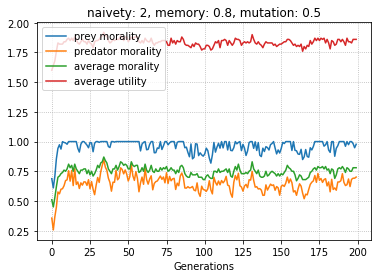

0.46 1.5
0.36 1.37
0.34 1.35
0.32 1.32
0.32 1.31
0.32 1.31
0.32 1.32
0.31 1.31
0.31 1.3
0.3 1.29
0.3 1.29
0.31 1.31
0.31 1.31
0.31 1.31
0.3 1.3
0.31 1.3
0.3 1.3
0.3 1.29
0.31 1.31
0.31 1.3
0.31 1.3
0.3 1.28
0.3 1.29
0.28 1.28
0.27 1.26
0.27 1.26
0.26 1.26
0.25 1.25
0.23 1.23
0.24 1.23
0.23 1.23
0.23 1.22
0.24 1.23
0.23 1.22
0.23 1.23
0.23 1.23
0.23 1.22
0.22 1.21
0.22 1.21
0.23 1.22
0.23 1.23
0.22 1.21
0.21 1.21
0.21 1.2
0.2 1.2
0.2 1.19
0.19 1.19
0.2 1.19
0.19 1.19
0.19 1.19
0.19 1.18
0.18 1.18
0.17 1.17
0.18 1.18
0.17 1.16
0.17 1.17
0.16 1.16
0.16 1.16
0.17 1.16
0.16 1.15
0.15 1.14
0.13 1.13
0.14 1.13
0.13 1.13
0.14 1.14
0.14 1.13
0.13 1.12
0.13 1.13
0.12 1.12
0.13 1.12
0.12 1.12
0.11 1.1
0.11 1.1
0.1 1.1
0.11 1.11
0.11 1.11
0.12 1.11
0.11 1.1
0.11 1.11
0.11 1.1
0.11 1.11
0.12 1.11
0.12 1.11
0.12 1.11
0.13 1.13
0.12 1.12
0.11 1.1
0.1 1.09
0.1 1.1
0.1 1.1
0.1 1.1
0.11 1.1
0.1 1.1
0.11 1.1
0.1 1.1
0.11 1.11
0.12 1.11
0.11 1.11
0.11 1.1
0.11 1.1
0.11 1.11
0.11 1.11
0.12 1.11
0.11 1.1
0.

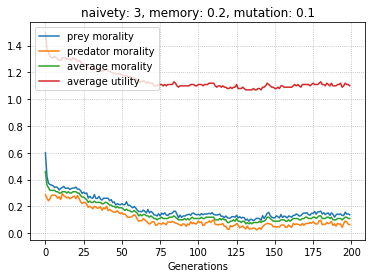

0.54 1.56
0.52 1.53
0.51 1.51
0.46 1.47
0.41 1.41
0.38 1.38
0.4 1.4
0.36 1.36
0.35 1.34
0.33 1.33
0.31 1.31
0.31 1.3
0.27 1.27
0.28 1.27
0.26 1.25
0.23 1.23
0.22 1.22
0.2 1.2
0.19 1.19
0.18 1.18
0.2 1.19
0.19 1.19
0.18 1.18
0.17 1.17
0.17 1.17
0.18 1.17
0.16 1.16
0.14 1.14
0.14 1.14
0.16 1.15
0.14 1.14
0.14 1.14
0.17 1.17
0.17 1.17
0.17 1.18
0.19 1.19
0.19 1.19
0.2 1.21
0.21 1.21
0.2 1.2
0.2 1.19
0.21 1.2
0.22 1.22
0.25 1.25
0.22 1.22
0.21 1.2
0.2 1.2
0.19 1.18
0.21 1.2
0.18 1.19
0.18 1.18
0.16 1.16
0.16 1.16
0.15 1.15
0.18 1.17
0.18 1.19
0.17 1.17
0.14 1.14
0.14 1.14
0.16 1.17
0.21 1.22
0.2 1.2
0.2 1.2
0.18 1.18
0.18 1.17
0.15 1.15
0.15 1.15
0.15 1.16
0.14 1.15
0.16 1.16
0.18 1.17
0.16 1.17
0.16 1.15
0.17 1.18
0.13 1.13
0.12 1.12
0.14 1.14
0.15 1.15
0.17 1.16
0.21 1.21
0.18 1.18
0.16 1.16
0.13 1.13
0.15 1.15
0.16 1.16
0.16 1.16
0.15 1.14
0.15 1.15
0.15 1.15
0.17 1.16
0.17 1.17
0.17 1.17
0.16 1.16
0.15 1.15
0.14 1.14
0.16 1.16
0.15 1.14
0.16 1.16
0.19 1.19
0.21 1.21
0.2 1.2
0.2 1.2
0.1

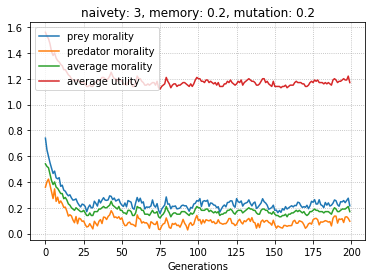

0.54 1.55
0.47 1.5
0.42 1.43
0.39 1.4
0.37 1.38
0.31 1.31
0.28 1.29
0.29 1.3
0.27 1.27
0.26 1.26
0.23 1.25
0.23 1.24
0.24 1.25
0.25 1.25
0.23 1.23
0.2 1.2
0.21 1.22
0.25 1.25
0.23 1.23
0.21 1.21
0.23 1.23
0.21 1.22
0.18 1.19
0.18 1.19
0.19 1.21
0.2 1.2
0.23 1.23
0.22 1.23
0.25 1.25
0.21 1.24
0.19 1.2
0.2 1.21
0.23 1.23
0.21 1.22
0.2 1.19
0.17 1.17
0.18 1.18
0.19 1.19
0.18 1.19
0.21 1.22
0.24 1.24
0.21 1.22
0.2 1.21
0.2 1.19
0.18 1.19
0.2 1.21
0.21 1.21
0.24 1.24
0.25 1.25
0.25 1.26
0.22 1.23
0.19 1.2
0.22 1.22
0.2 1.21
0.18 1.19
0.2 1.21
0.21 1.21
0.22 1.23
0.25 1.25
0.28 1.3
0.27 1.27
0.25 1.25
0.23 1.24
0.23 1.25
0.25 1.24
0.24 1.24
0.22 1.23
0.23 1.24
0.19 1.2
0.22 1.22
0.22 1.24
0.22 1.24
0.24 1.25
0.21 1.22
0.2 1.2
0.22 1.24
0.2 1.21
0.24 1.24
0.23 1.24
0.28 1.28
0.29 1.29
0.25 1.25
0.23 1.23
0.24 1.24
0.22 1.23
0.22 1.22
0.21 1.22
0.22 1.22
0.23 1.24
0.28 1.29
0.28 1.28
0.23 1.23
0.22 1.23
0.2 1.21
0.19 1.18
0.18 1.19
0.22 1.21
0.25 1.26
0.28 1.29
0.26 1.27
0.23 1.24
0.22 1.22
0.

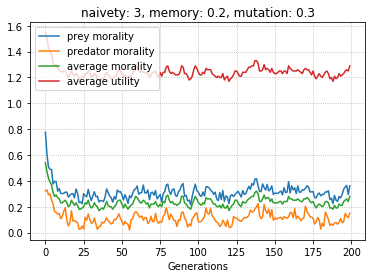

0.52 1.53
0.48 1.49
0.41 1.43
0.38 1.39
0.34 1.38
0.29 1.32
0.27 1.3
0.28 1.28
0.22 1.25
0.26 1.27
0.31 1.31
0.31 1.34
0.29 1.31
0.33 1.34
0.3 1.33
0.3 1.33
0.29 1.29
0.27 1.28
0.27 1.3
0.29 1.3
0.24 1.25
0.25 1.27
0.25 1.26
0.23 1.25
0.22 1.23
0.26 1.28
0.23 1.25
0.24 1.24
0.24 1.26
0.25 1.29
0.24 1.24
0.28 1.27
0.27 1.29
0.28 1.3
0.29 1.29
0.3 1.3
0.23 1.25
0.21 1.21
0.21 1.24
0.23 1.27
0.28 1.28
0.27 1.29
0.27 1.29
0.28 1.31
0.3 1.31
0.31 1.37
0.31 1.32
0.26 1.28
0.25 1.28
0.27 1.29
0.26 1.34
0.28 1.3
0.23 1.24
0.25 1.27
0.3 1.31
0.29 1.3
0.24 1.27
0.24 1.24
0.23 1.25
0.24 1.27
0.28 1.3
0.26 1.28
0.28 1.29
0.28 1.3
0.29 1.31
0.28 1.33
0.24 1.25
0.25 1.26
0.29 1.3
0.29 1.29
0.25 1.28
0.22 1.24
0.2 1.21
0.19 1.19
0.18 1.18
0.21 1.21
0.21 1.26
0.22 1.23
0.24 1.26
0.21 1.2
0.21 1.21
0.18 1.19
0.21 1.23
0.24 1.25
0.24 1.25
0.25 1.28
0.25 1.27
0.27 1.3
0.25 1.28
0.25 1.27
0.24 1.24
0.24 1.25
0.23 1.25
0.24 1.25
0.3 1.37
0.27 1.28
0.21 1.22
0.2 1.21
0.18 1.19
0.23 1.23
0.23 1.23
0.23 1.25


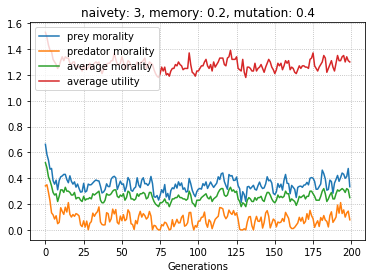

0.52 1.53
0.49 1.51
0.48 1.52
0.42 1.43
0.39 1.45
0.32 1.41
0.25 1.26
0.24 1.29
0.25 1.27
0.29 1.31
0.31 1.36
0.31 1.42
0.27 1.29
0.28 1.31
0.3 1.37
0.3 1.34
0.3 1.32
0.28 1.31
0.3 1.33
0.29 1.33
0.26 1.36
0.2 1.25
0.25 1.28
0.22 1.23
0.24 1.26
0.29 1.3
0.27 1.39
0.26 1.3
0.3 1.32
0.33 1.43
0.33 1.39
0.27 1.31
0.28 1.32
0.24 1.25
0.28 1.3
0.32 1.35
0.26 1.29
0.25 1.31
0.23 1.28
0.22 1.24
0.21 1.21
0.23 1.25
0.24 1.27
0.25 1.28
0.27 1.3
0.26 1.28
0.27 1.31
0.27 1.28
0.26 1.29
0.27 1.35
0.27 1.3
0.25 1.29
0.28 1.38
0.32 1.34
0.34 1.4
0.24 1.26
0.28 1.31
0.27 1.3
0.22 1.23
0.22 1.24
0.25 1.28
0.24 1.28
0.27 1.27
0.28 1.29
0.25 1.26
0.26 1.28
0.32 1.34
0.35 1.37
0.37 1.38
0.35 1.39
0.29 1.39
0.25 1.27
0.26 1.39
0.24 1.25
0.31 1.36
0.28 1.31
0.28 1.33
0.28 1.37
0.22 1.25
0.21 1.3
0.23 1.27
0.23 1.25
0.25 1.31
0.23 1.23
0.23 1.24
0.25 1.26
0.27 1.29
0.26 1.29
0.33 1.43
0.28 1.3
0.29 1.3
0.29 1.39
0.23 1.25
0.29 1.31
0.32 1.39
0.33 1.36
0.25 1.26
0.22 1.24
0.25 1.25
0.27 1.28
0.31 1.39
0.31 1

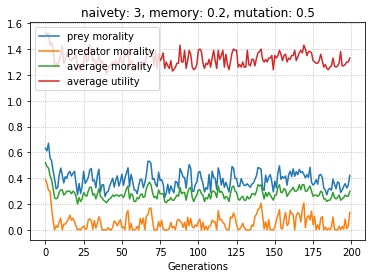

0.54 1.56
0.52 1.51
0.51 1.51
0.51 1.5
0.51 1.5
0.49 1.47
0.49 1.48
0.5 1.5
0.5 1.5
0.51 1.5
0.51 1.51
0.53 1.53
0.53 1.52
0.52 1.52
0.52 1.52
0.52 1.5
0.51 1.5
0.51 1.51
0.51 1.5
0.5 1.5
0.49 1.48
0.48 1.48
0.47 1.47
0.48 1.47
0.48 1.47
0.48 1.48
0.48 1.48
0.48 1.47
0.48 1.47
0.48 1.47
0.47 1.47
0.47 1.46
0.45 1.44
0.46 1.46
0.47 1.46
0.46 1.45
0.46 1.45
0.45 1.44
0.45 1.45
0.45 1.44
0.44 1.43
0.44 1.44
0.42 1.41
0.41 1.4
0.41 1.4
0.41 1.4
0.41 1.4
0.39 1.38
0.38 1.38
0.38 1.37
0.36 1.34
0.34 1.33
0.34 1.33
0.34 1.34
0.32 1.32
0.31 1.3
0.31 1.31
0.33 1.32
0.33 1.32
0.33 1.32
0.33 1.33
0.33 1.32
0.33 1.33
0.33 1.32
0.34 1.34
0.33 1.33
0.33 1.32
0.33 1.33
0.34 1.34
0.34 1.34
0.34 1.33
0.34 1.34
0.35 1.35
0.35 1.35
0.35 1.35
0.34 1.33
0.35 1.35
0.35 1.35
0.35 1.34
0.35 1.34
0.34 1.33
0.33 1.33
0.33 1.32
0.32 1.32
0.32 1.32
0.32 1.32
0.32 1.31
0.3 1.3
0.3 1.29
0.3 1.29
0.29 1.28
0.29 1.28
0.28 1.28
0.27 1.26
0.27 1.25
0.26 1.25
0.26 1.25
0.26 1.26
0.26 1.25
0.25 1.25
0.24 1.24
0.24 1.24
0

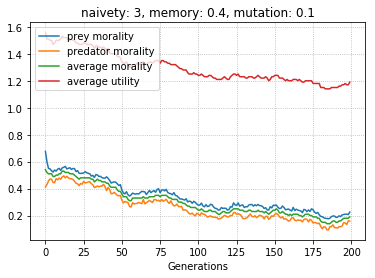

0.53 1.53
0.55 1.55
0.55 1.55
0.56 1.56
0.54 1.54
0.53 1.53
0.52 1.52
0.51 1.51
0.5 1.49
0.48 1.48
0.43 1.43
0.44 1.44
0.44 1.43
0.43 1.43
0.4 1.4
0.4 1.4
0.38 1.38
0.4 1.39
0.41 1.41
0.4 1.4
0.37 1.37
0.37 1.37
0.33 1.32
0.32 1.32
0.33 1.33
0.32 1.32
0.3 1.3
0.26 1.26
0.22 1.22
0.21 1.21
0.19 1.19
0.21 1.21
0.24 1.23
0.22 1.23
0.23 1.22
0.24 1.24
0.25 1.24
0.24 1.23
0.23 1.23
0.23 1.23
0.22 1.22
0.23 1.23
0.23 1.24
0.22 1.21
0.22 1.22
0.22 1.22
0.23 1.22
0.24 1.24
0.23 1.23
0.23 1.23
0.2 1.2
0.17 1.17
0.2 1.2
0.17 1.17
0.17 1.16
0.18 1.17
0.18 1.17
0.18 1.18
0.16 1.17
0.14 1.15
0.14 1.13
0.15 1.16
0.15 1.15
0.16 1.16
0.17 1.16
0.19 1.18
0.18 1.18
0.19 1.2
0.19 1.19
0.18 1.18
0.18 1.18
0.18 1.17
0.17 1.17
0.18 1.18
0.17 1.17
0.18 1.18
0.18 1.18
0.18 1.18
0.2 1.19
0.2 1.2
0.18 1.18
0.2 1.2
0.23 1.23
0.24 1.24
0.24 1.23
0.21 1.21
0.21 1.21
0.21 1.21
0.22 1.22
0.22 1.23
0.19 1.19
0.19 1.2
0.18 1.19
0.19 1.19
0.19 1.19
0.19 1.19
0.19 1.19
0.18 1.19
0.18 1.18
0.2 1.2
0.22 1.21
0.21 1.22
0.2

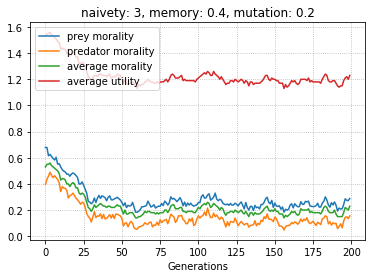

0.52 1.52
0.48 1.5
0.42 1.43
0.41 1.42
0.4 1.41
0.41 1.41
0.41 1.41
0.41 1.42
0.38 1.39
0.39 1.39
0.37 1.37
0.39 1.39
0.39 1.39
0.37 1.38
0.37 1.37
0.39 1.38
0.37 1.36
0.37 1.38
0.38 1.39
0.37 1.38
0.35 1.36
0.33 1.34
0.33 1.35
0.34 1.34
0.29 1.29
0.26 1.26
0.27 1.27
0.26 1.27
0.25 1.25
0.25 1.27
0.25 1.27
0.28 1.28
0.28 1.29
0.26 1.27
0.27 1.28
0.27 1.27
0.25 1.26
0.29 1.33
0.25 1.25
0.25 1.26
0.24 1.25
0.23 1.23
0.2 1.21
0.2 1.2
0.2 1.21
0.2 1.19
0.2 1.2
0.21 1.21
0.22 1.22
0.21 1.22
0.23 1.23
0.22 1.22
0.23 1.23
0.23 1.23
0.22 1.23
0.23 1.24
0.23 1.24
0.23 1.23
0.22 1.23
0.21 1.22
0.22 1.23
0.2 1.22
0.19 1.2
0.21 1.21
0.21 1.21
0.21 1.21
0.2 1.21
0.22 1.22
0.19 1.19
0.21 1.22
0.23 1.25
0.22 1.23
0.2 1.2
0.21 1.22
0.17 1.17
0.2 1.2
0.24 1.24
0.24 1.25
0.22 1.22
0.21 1.21
0.23 1.24
0.23 1.23
0.23 1.23
0.21 1.22
0.19 1.18
0.23 1.23
0.22 1.22
0.24 1.25
0.23 1.24
0.23 1.23
0.23 1.23
0.2 1.2
0.2 1.21
0.18 1.18
0.19 1.19
0.18 1.18
0.19 1.19
0.19 1.19
0.22 1.23
0.21 1.21
0.24 1.24
0.25 1.26

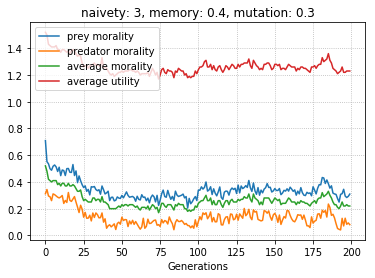

0.52 1.53
0.49 1.51
0.52 1.53
0.45 1.47
0.38 1.4
0.33 1.35
0.38 1.43
0.32 1.4
0.32 1.35
0.27 1.28
0.24 1.25
0.25 1.26
0.21 1.22
0.25 1.26
0.28 1.28
0.3 1.32
0.31 1.33
0.27 1.3
0.28 1.31
0.32 1.34
0.3 1.33
0.32 1.34
0.31 1.33
0.33 1.34
0.35 1.38
0.32 1.34
0.27 1.28
0.27 1.3
0.27 1.28
0.29 1.31
0.28 1.29
0.28 1.31
0.29 1.3
0.29 1.32
0.26 1.36
0.22 1.23
0.24 1.25
0.28 1.28
0.27 1.28
0.32 1.33
0.28 1.29
0.27 1.27
0.27 1.28
0.28 1.31
0.27 1.3
0.3 1.33
0.27 1.28
0.3 1.31
0.32 1.34
0.32 1.34
0.35 1.36
0.37 1.4
0.39 1.41
0.4 1.44
0.37 1.38
0.34 1.38
0.33 1.38
0.3 1.32
0.27 1.3
0.25 1.25
0.24 1.27
0.26 1.33
0.25 1.27
0.29 1.3
0.29 1.34
0.23 1.24
0.25 1.27
0.28 1.29
0.33 1.33
0.32 1.32
0.27 1.28
0.28 1.29
0.32 1.34
0.33 1.34
0.36 1.38
0.35 1.36
0.33 1.34
0.28 1.31
0.27 1.33
0.25 1.26
0.3 1.3
0.28 1.28
0.29 1.32
0.29 1.3
0.29 1.3
0.31 1.33
0.26 1.27
0.28 1.34
0.25 1.27
0.32 1.33
0.28 1.35
0.3 1.32
0.33 1.38
0.32 1.34
0.29 1.31
0.23 1.33
0.22 1.23
0.19 1.2
0.22 1.28
0.21 1.22
0.19 1.21
0.2 1.21
0.

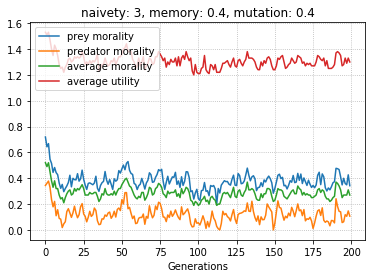

0.48 1.5
0.47 1.51
0.43 1.46
0.39 1.45
0.34 1.39
0.31 1.39
0.35 1.38
0.3 1.36
0.28 1.31
0.28 1.3
0.31 1.35
0.28 1.37
0.29 1.36
0.27 1.29
0.28 1.35
0.31 1.33
0.3 1.34
0.28 1.35
0.22 1.24
0.29 1.3
0.27 1.34
0.23 1.28
0.21 1.23
0.22 1.26
0.24 1.26
0.27 1.27
0.26 1.28
0.31 1.34
0.29 1.31
0.25 1.32
0.33 1.34
0.27 1.29
0.32 1.34
0.32 1.33
0.4 1.42
0.38 1.44
0.33 1.36
0.33 1.4
0.35 1.36
0.29 1.3
0.26 1.3
0.25 1.32
0.28 1.29
0.31 1.33
0.25 1.28
0.23 1.34
0.25 1.27
0.28 1.31
0.32 1.34
0.34 1.41
0.3 1.33
0.3 1.33
0.27 1.3
0.31 1.35
0.31 1.32
0.35 1.38
0.38 1.4
0.35 1.43
0.3 1.34
0.32 1.35
0.31 1.36
0.33 1.35
0.35 1.37
0.33 1.42
0.28 1.35
0.27 1.34
0.23 1.27
0.29 1.34
0.31 1.41
0.32 1.36
0.31 1.32
0.35 1.38
0.36 1.41
0.36 1.42
0.36 1.41
0.31 1.4
0.3 1.35
0.3 1.38
0.32 1.39
0.32 1.36
0.34 1.35
0.32 1.34
0.28 1.32
0.29 1.35
0.28 1.35
0.24 1.25
0.24 1.25
0.26 1.28
0.28 1.28
0.32 1.33
0.31 1.33
0.34 1.36
0.35 1.43
0.32 1.36
0.3 1.33
0.33 1.42
0.34 1.37
0.33 1.37
0.3 1.32
0.34 1.39
0.32 1.36
0.29 1.31

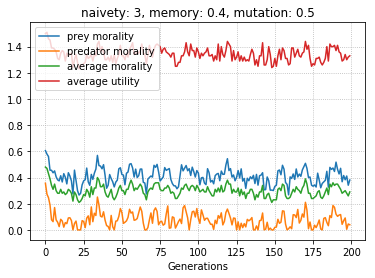

0.47 1.48
0.48 1.48
0.46 1.46
0.44 1.44
0.45 1.45
0.45 1.44
0.44 1.43
0.43 1.43
0.43 1.42
0.42 1.42
0.42 1.42
0.42 1.41
0.44 1.43
0.45 1.45
0.44 1.44
0.45 1.44
0.45 1.45
0.46 1.46
0.46 1.46
0.46 1.45
0.46 1.45
0.46 1.46
0.46 1.46
0.47 1.46
0.47 1.46
0.47 1.46
0.46 1.46
0.47 1.47
0.47 1.46
0.47 1.46
0.47 1.47
0.48 1.48
0.48 1.47
0.47 1.47
0.47 1.47
0.47 1.47
0.47 1.46
0.47 1.46
0.48 1.47
0.46 1.46
0.47 1.46
0.47 1.47
0.47 1.46
0.47 1.47
0.46 1.46
0.47 1.46
0.48 1.48
0.47 1.47
0.47 1.47
0.46 1.45
0.47 1.47
0.47 1.46
0.46 1.45
0.47 1.46
0.48 1.48
0.48 1.48
0.48 1.48
0.47 1.47
0.46 1.46
0.48 1.47
0.49 1.48
0.47 1.46
0.47 1.46
0.48 1.48
0.5 1.49
0.49 1.48
0.49 1.49
0.49 1.49
0.5 1.48
0.51 1.51
0.51 1.5
0.5 1.49
0.49 1.49
0.48 1.47
0.47 1.46
0.48 1.47
0.46 1.46
0.48 1.47
0.48 1.48
0.49 1.48
0.49 1.48
0.5 1.49
0.48 1.47
0.48 1.48
0.48 1.47
0.47 1.46
0.47 1.47
0.48 1.47
0.48 1.47
0.49 1.48
0.5 1.49
0.5 1.49
0.5 1.5
0.5 1.5
0.5 1.5
0.5 1.5
0.5 1.49
0.5 1.49
0.5 1.49
0.5 1.49
0.53 1.51
0.53 1.53

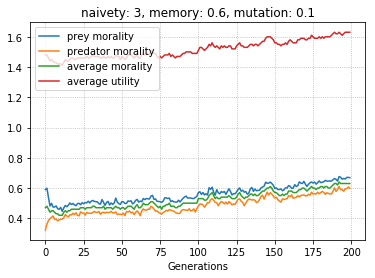

0.51 1.52
0.46 1.47
0.43 1.43
0.43 1.43
0.42 1.43
0.42 1.43
0.42 1.43
0.41 1.42
0.39 1.4
0.37 1.37
0.37 1.38
0.35 1.36
0.33 1.33
0.33 1.32
0.34 1.35
0.35 1.36
0.37 1.37
0.36 1.37
0.37 1.38
0.38 1.38
0.33 1.34
0.34 1.34
0.34 1.34
0.36 1.36
0.35 1.36
0.33 1.34
0.35 1.35
0.32 1.32
0.35 1.35
0.31 1.31
0.28 1.29
0.28 1.28
0.26 1.26
0.24 1.25
0.24 1.24
0.24 1.25
0.24 1.24
0.23 1.24
0.25 1.25
0.26 1.26
0.24 1.24
0.24 1.23
0.25 1.25
0.24 1.24
0.26 1.26
0.24 1.23
0.23 1.23
0.24 1.24
0.26 1.27
0.26 1.27
0.27 1.28
0.28 1.29
0.29 1.29
0.27 1.28
0.27 1.27
0.29 1.3
0.28 1.28
0.29 1.29
0.26 1.27
0.27 1.27
0.25 1.25
0.26 1.26
0.25 1.25
0.23 1.23
0.23 1.23
0.22 1.22
0.23 1.23
0.22 1.22
0.21 1.21
0.21 1.21
0.2 1.2
0.22 1.22
0.21 1.21
0.23 1.23
0.24 1.24
0.24 1.23
0.24 1.25
0.25 1.26
0.24 1.24
0.24 1.25
0.25 1.26
0.26 1.26
0.26 1.26
0.27 1.28
0.29 1.29
0.3 1.31
0.33 1.33
0.35 1.35
0.35 1.35
0.36 1.36
0.34 1.35
0.31 1.31
0.3 1.3
0.31 1.31
0.3 1.3
0.32 1.33
0.34 1.34
0.35 1.34
0.35 1.35
0.35 1.35
0.32 1.32

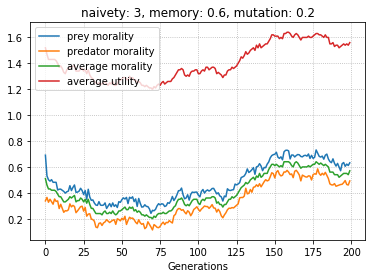

0.55 1.56
0.5 1.53
0.5 1.51
0.47 1.47
0.47 1.48
0.45 1.45
0.43 1.44
0.45 1.46
0.42 1.45
0.43 1.44
0.45 1.46
0.43 1.44
0.41 1.42
0.43 1.44
0.44 1.44
0.44 1.45
0.42 1.42
0.43 1.43
0.41 1.43
0.41 1.42
0.42 1.43
0.42 1.43
0.44 1.45
0.48 1.5
0.45 1.45
0.44 1.45
0.43 1.45
0.45 1.46
0.46 1.48
0.5 1.5
0.53 1.53
0.52 1.52
0.51 1.51
0.51 1.52
0.52 1.52
0.54 1.55
0.53 1.54
0.52 1.53
0.52 1.52
0.49 1.5
0.49 1.5
0.46 1.47
0.46 1.47
0.46 1.47
0.42 1.43
0.43 1.43
0.41 1.44
0.38 1.4
0.37 1.38
0.39 1.4
0.38 1.39
0.36 1.37
0.35 1.36
0.34 1.36
0.36 1.37
0.36 1.38
0.35 1.37
0.33 1.37
0.34 1.36
0.31 1.32
0.32 1.33
0.3 1.31
0.28 1.3
0.29 1.3
0.3 1.32
0.38 1.39
0.33 1.35
0.34 1.35
0.32 1.34
0.32 1.33
0.35 1.36
0.31 1.33
0.32 1.34
0.33 1.34
0.3 1.31
0.28 1.29
0.25 1.27
0.26 1.28
0.26 1.29
0.27 1.28
0.25 1.26
0.26 1.27
0.29 1.29
0.33 1.35
0.33 1.35
0.33 1.34
0.33 1.34
0.3 1.33
0.31 1.33
0.32 1.34
0.33 1.35
0.35 1.37
0.37 1.38
0.34 1.38
0.32 1.34
0.32 1.32
0.33 1.35
0.31 1.33
0.3 1.31
0.32 1.34
0.35 1.36
0.34 1

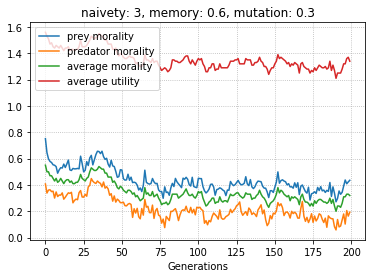

0.54 1.55
0.52 1.53
0.48 1.5
0.43 1.43
0.44 1.47
0.42 1.44
0.36 1.42
0.31 1.34
0.29 1.31
0.34 1.35
0.33 1.35
0.32 1.36
0.33 1.36
0.37 1.42
0.35 1.37
0.36 1.39
0.38 1.43
0.29 1.3
0.28 1.31
0.26 1.34
0.25 1.34
0.21 1.24
0.26 1.28
0.28 1.31
0.34 1.36
0.35 1.37
0.34 1.4
0.36 1.4
0.34 1.37
0.36 1.42
0.31 1.34
0.28 1.31
0.28 1.3
0.31 1.33
0.37 1.38
0.37 1.41
0.41 1.43
0.34 1.36
0.36 1.38
0.38 1.41
0.32 1.34
0.36 1.39
0.37 1.4
0.35 1.37
0.33 1.38
0.33 1.36
0.35 1.37
0.34 1.38
0.31 1.33
0.3 1.33
0.3 1.31
0.27 1.3
0.35 1.37
0.34 1.36
0.33 1.36
0.32 1.35
0.29 1.37
0.25 1.29
0.26 1.32
0.29 1.32
0.32 1.34
0.38 1.39
0.39 1.41
0.38 1.41
0.38 1.4
0.37 1.42
0.38 1.42
0.36 1.39
0.3 1.31
0.29 1.31
0.25 1.27
0.28 1.31
0.33 1.34
0.36 1.39
0.37 1.38
0.4 1.43
0.36 1.39
0.4 1.41
0.42 1.44
0.37 1.41
0.33 1.37
0.34 1.39
0.3 1.32
0.3 1.33
0.33 1.36
0.33 1.35
0.32 1.35
0.33 1.37
0.34 1.38
0.32 1.34
0.33 1.36
0.37 1.39
0.38 1.4
0.39 1.42
0.41 1.43
0.39 1.4
0.38 1.39
0.39 1.41
0.37 1.39
0.35 1.37
0.33 1.35
0.34 1.

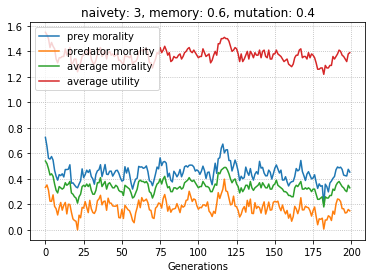

0.5 1.51
0.47 1.51
0.38 1.41
0.37 1.41
0.37 1.42
0.39 1.42
0.41 1.44
0.4 1.43
0.34 1.39
0.35 1.39
0.34 1.39
0.35 1.41
0.38 1.41
0.35 1.42
0.33 1.43
0.34 1.41
0.32 1.36
0.28 1.31
0.31 1.33
0.33 1.35
0.37 1.39
0.37 1.41
0.33 1.36
0.32 1.35
0.35 1.38
0.34 1.38
0.39 1.42
0.37 1.41
0.37 1.41
0.4 1.43
0.38 1.43
0.36 1.41
0.34 1.38
0.32 1.37
0.29 1.33
0.24 1.28
0.27 1.31
0.24 1.26
0.25 1.28
0.34 1.37
0.33 1.35
0.4 1.43
0.41 1.45
0.38 1.45
0.37 1.4
0.31 1.34
0.38 1.42
0.43 1.47
0.36 1.39
0.33 1.41
0.36 1.39
0.34 1.38
0.33 1.36
0.32 1.35
0.35 1.39
0.38 1.41
0.43 1.45
0.48 1.5
0.44 1.49
0.44 1.48
0.39 1.45
0.38 1.41
0.36 1.38
0.35 1.43
0.31 1.34
0.31 1.34
0.27 1.35
0.28 1.31
0.29 1.33
0.31 1.35
0.34 1.41
0.33 1.36
0.34 1.38
0.32 1.38
0.29 1.32
0.27 1.35
0.26 1.3
0.25 1.29
0.29 1.32
0.3 1.33
0.3 1.36
0.32 1.35
0.32 1.39
0.28 1.32
0.3 1.36
0.28 1.35
0.31 1.35
0.34 1.38
0.31 1.39
0.32 1.4
0.31 1.41
0.29 1.32
0.27 1.31
0.31 1.34
0.35 1.39
0.37 1.39
0.34 1.41
0.29 1.37
0.27 1.32
0.27 1.3
0.28 1.3
0.3

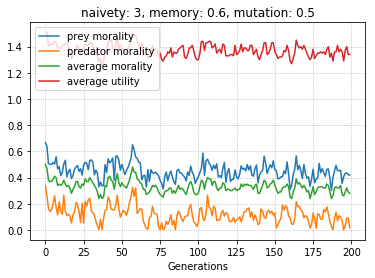

0.52 1.54
0.52 1.53
0.5 1.51
0.52 1.52
0.52 1.52
0.52 1.52
0.53 1.53
0.51 1.5
0.49 1.49
0.49 1.49
0.5 1.5
0.5 1.49
0.49 1.49
0.48 1.48
0.49 1.49
0.5 1.49
0.5 1.5
0.5 1.51
0.51 1.51
0.5 1.5
0.5 1.49
0.51 1.51
0.51 1.51
0.5 1.49
0.5 1.5
0.5 1.49
0.51 1.5
0.5 1.5
0.49 1.49
0.5 1.49
0.5 1.5
0.51 1.5
0.52 1.52
0.52 1.51
0.52 1.51
0.53 1.52
0.53 1.52
0.52 1.52
0.52 1.52
0.51 1.5
0.51 1.51
0.52 1.51
0.53 1.52
0.53 1.53
0.53 1.53
0.54 1.53
0.53 1.53
0.53 1.52
0.55 1.54
0.54 1.53
0.53 1.52
0.52 1.52
0.52 1.53
0.51 1.5
0.49 1.5
0.5 1.5
0.49 1.5
0.49 1.49
0.49 1.48
0.49 1.49
0.49 1.49
0.48 1.48
0.48 1.47
0.48 1.47
0.48 1.47
0.48 1.48
0.49 1.49
0.5 1.49
0.49 1.49
0.51 1.5
0.51 1.51
0.5 1.5
0.5 1.5
0.51 1.51
0.52 1.51
0.53 1.53
0.52 1.51
0.52 1.52
0.51 1.5
0.5 1.5
0.49 1.49
0.5 1.5
0.5 1.5
0.51 1.51
0.53 1.53
0.55 1.55
0.56 1.55
0.55 1.55
0.57 1.57
0.58 1.58
0.58 1.57
0.57 1.57
0.58 1.58
0.59 1.59
0.59 1.58
0.6 1.59
0.61 1.61
0.61 1.6
0.6 1.6
0.6 1.6
0.6 1.59
0.6 1.6
0.6 1.6
0.6 1.6
0.6 1.6
0.6 1.5

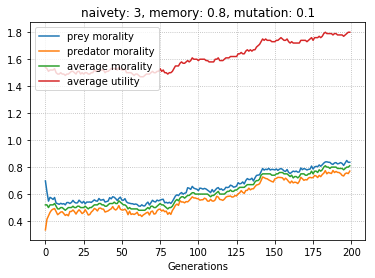

0.47 1.5
0.46 1.48
0.45 1.47
0.46 1.48
0.46 1.46
0.47 1.48
0.46 1.47
0.46 1.47
0.5 1.5
0.51 1.52
0.52 1.53
0.53 1.53
0.55 1.55
0.53 1.54
0.52 1.52
0.52 1.53
0.55 1.56
0.56 1.56
0.56 1.56
0.57 1.56
0.58 1.59
0.57 1.58
0.57 1.56
0.56 1.56
0.56 1.56
0.57 1.57
0.58 1.58
0.55 1.55
0.53 1.53
0.55 1.56
0.57 1.57
0.58 1.58
0.58 1.59
0.6 1.61
0.59 1.6
0.58 1.58
0.58 1.59
0.57 1.58
0.58 1.59
0.56 1.56
0.57 1.57
0.58 1.59
0.59 1.59
0.63 1.63
0.64 1.64
0.65 1.65
0.66 1.65
0.65 1.66
0.69 1.69
0.7 1.71
0.71 1.71
0.71 1.7
0.69 1.69
0.71 1.71
0.72 1.72
0.71 1.71
0.72 1.72
0.73 1.72
0.73 1.73
0.73 1.73
0.75 1.75
0.77 1.76
0.76 1.76
0.75 1.75
0.74 1.74
0.75 1.75
0.75 1.75
0.76 1.76
0.77 1.77
0.76 1.75
0.78 1.78
0.79 1.79
0.79 1.79
0.76 1.76
0.76 1.75
0.76 1.76
0.76 1.76
0.74 1.73
0.73 1.72
0.73 1.73
0.73 1.73
0.74 1.73
0.73 1.73
0.71 1.71
0.72 1.71
0.73 1.72
0.72 1.71
0.76 1.76
0.74 1.74
0.73 1.72
0.69 1.69
0.7 1.71
0.7 1.7
0.71 1.7
0.67 1.67
0.68 1.67
0.69 1.69
0.67 1.68
0.68 1.68
0.68 1.67
0.66 1.66
0

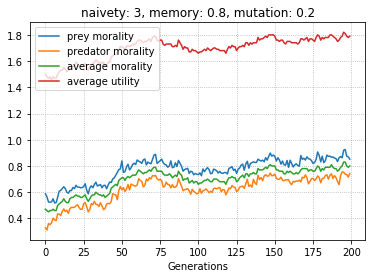

0.53 1.55
0.52 1.54
0.5 1.51
0.48 1.51
0.46 1.49
0.47 1.49
0.44 1.47
0.42 1.45
0.44 1.47
0.44 1.46
0.46 1.47
0.45 1.47
0.5 1.51
0.48 1.51
0.47 1.49
0.44 1.47
0.45 1.48
0.46 1.49
0.41 1.44
0.36 1.39
0.41 1.44
0.39 1.42
0.42 1.45
0.4 1.42
0.4 1.42
0.4 1.43
0.4 1.44
0.47 1.49
0.48 1.5
0.49 1.51
0.45 1.48
0.45 1.47
0.44 1.46
0.49 1.5
0.49 1.51
0.46 1.49
0.46 1.49
0.43 1.45
0.42 1.45
0.42 1.45
0.41 1.44
0.42 1.45
0.46 1.48
0.44 1.46
0.44 1.46
0.44 1.46
0.41 1.44
0.41 1.43
0.44 1.48
0.45 1.47
0.42 1.45
0.37 1.4
0.39 1.41
0.37 1.39
0.34 1.36
0.36 1.38
0.35 1.39
0.37 1.39
0.39 1.41
0.42 1.44
0.43 1.44
0.41 1.44
0.42 1.44
0.37 1.39
0.38 1.4
0.39 1.41
0.39 1.42
0.43 1.45
0.42 1.45
0.42 1.44
0.46 1.47
0.46 1.47
0.46 1.47
0.43 1.44
0.45 1.47
0.46 1.48
0.45 1.46
0.46 1.47
0.43 1.45
0.44 1.45
0.44 1.45
0.43 1.45
0.44 1.45
0.47 1.49
0.53 1.54
0.53 1.55
0.53 1.55
0.52 1.54
0.52 1.53
0.48 1.51
0.45 1.47
0.41 1.43
0.41 1.44
0.47 1.49
0.43 1.45
0.51 1.52
0.5 1.51
0.53 1.54
0.55 1.57
0.58 1.59
0.59 1.59
0

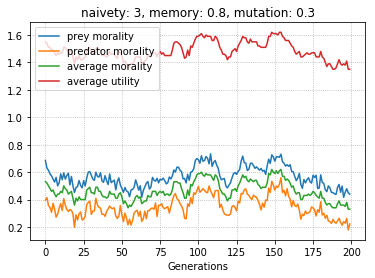

0.51 1.53
0.48 1.51
0.46 1.48
0.43 1.46
0.48 1.51
0.47 1.5
0.46 1.49
0.48 1.52
0.54 1.56
0.51 1.54
0.48 1.51
0.49 1.52
0.46 1.5
0.45 1.48
0.45 1.5
0.47 1.51
0.44 1.48
0.41 1.45
0.44 1.48
0.49 1.53
0.5 1.53
0.57 1.59
0.54 1.56
0.52 1.55
0.49 1.52
0.49 1.52
0.48 1.51
0.46 1.49
0.49 1.52
0.45 1.48
0.43 1.47
0.45 1.48
0.43 1.46
0.41 1.46
0.38 1.43
0.38 1.41
0.41 1.47
0.43 1.46
0.39 1.47
0.4 1.43
0.35 1.38
0.4 1.43
0.41 1.46
0.4 1.45
0.4 1.46
0.34 1.38
0.32 1.38
0.36 1.4
0.4 1.43
0.44 1.48
0.42 1.46
0.36 1.41
0.33 1.37
0.34 1.39
0.32 1.37
0.32 1.38
0.34 1.39
0.32 1.36
0.35 1.39
0.35 1.41
0.34 1.38
0.35 1.39
0.34 1.38
0.33 1.38
0.32 1.37
0.38 1.43
0.4 1.43
0.43 1.47
0.42 1.47
0.47 1.51
0.41 1.46
0.45 1.48
0.42 1.46
0.42 1.45
0.43 1.45
0.44 1.46
0.44 1.47
0.39 1.44
0.42 1.45
0.4 1.44
0.42 1.46
0.41 1.43
0.41 1.46
0.35 1.38
0.37 1.4
0.38 1.43
0.34 1.4
0.35 1.42
0.34 1.38
0.33 1.41
0.29 1.35
0.3 1.36
0.33 1.37
0.38 1.41
0.36 1.41
0.35 1.39
0.38 1.42
0.37 1.41
0.37 1.41
0.37 1.43
0.37 1.4
0.43 1

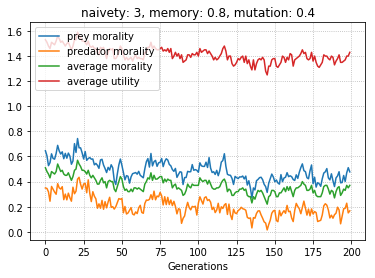

0.48 1.51
0.49 1.53
0.49 1.53
0.49 1.53
0.43 1.48
0.41 1.47
0.39 1.46
0.38 1.42
0.35 1.41
0.35 1.39
0.32 1.36
0.28 1.34
0.33 1.37
0.31 1.35
0.36 1.42
0.36 1.39
0.38 1.45
0.35 1.41
0.29 1.34
0.29 1.34
0.27 1.35
0.3 1.36
0.28 1.33
0.32 1.4
0.32 1.38
0.34 1.4
0.31 1.4
0.35 1.39
0.33 1.37
0.41 1.45
0.42 1.49
0.4 1.46
0.41 1.46
0.39 1.45
0.35 1.41
0.36 1.4
0.4 1.47
0.4 1.46
0.42 1.49
0.38 1.43
0.36 1.42
0.38 1.42
0.44 1.5
0.42 1.48
0.39 1.46
0.38 1.46
0.35 1.43
0.34 1.41
0.35 1.39
0.37 1.42
0.37 1.42
0.38 1.42
0.39 1.45
0.38 1.43
0.36 1.41
0.37 1.43
0.34 1.4
0.36 1.41
0.41 1.44
0.41 1.48
0.42 1.46
0.36 1.42
0.34 1.42
0.36 1.41
0.37 1.42
0.38 1.45
0.36 1.42
0.42 1.49
0.43 1.48
0.38 1.46
0.39 1.44
0.4 1.44
0.43 1.46
0.44 1.49
0.4 1.45
0.41 1.46
0.44 1.49
0.4 1.46
0.37 1.44
0.38 1.45
0.33 1.43
0.29 1.36
0.3 1.35
0.3 1.37
0.32 1.38
0.33 1.4
0.34 1.43
0.35 1.41
0.36 1.42
0.37 1.46
0.36 1.43
0.34 1.41
0.3 1.37
0.26 1.32
0.32 1.39
0.3 1.39
0.34 1.39
0.38 1.43
0.39 1.45
0.39 1.45
0.38 1.45
0.38 1.4

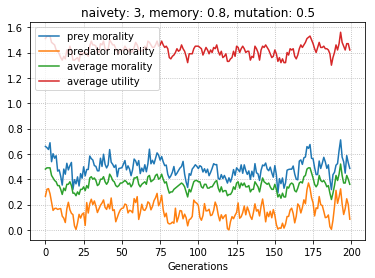

In [5]:
# iterate over a number of combinations of naiv, mem, and mut values
naivs = [0, 1, 2, 3]
mems = [0.2, 0.4, 0.6, 0.8]
muts = [0.1, 0.2, 0.3, 0.4, 0.5]

for naiv in naivs:
    for mem in mems:
        for mut in muts:
            e = evolution(100,   # size
                          naiv,  # naivety
                          mem,   # memory
                          mut,   # mutation
                          100)   # interactions
            e.evolve_gens(200,   # generations
                          True)  # graph